<a href="https://colab.research.google.com/github/benpcorn/DLH598-Team144/blob/main/DL4H_Team_144_BCORN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Team 144
bcorn2@uiuc.edu | Benjamin Corn

Github Repo: https://github.com/benpcorn/DLH598-Team144

Video Presentation: <TODO>

Paper Repo: https://github.com/tufts-ml/SAMIL/tree/main

Paper PDF: https://arxiv.org/pdf/2306.00003

## Problem

Huang, Zhe, Wessler, Benjamin S., and Hughes, Michael C. (2023) – Detecting Heart
Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance
Learning describes the clinical problem of under-diagnosis and under-treatment
of aortic stenosis (AS), a degenerative valve condition. In clinical practice, AS is diagnosed
by manual expert view of a transthoracic echocardiography (TTE) – which uses ultrasound
to produce many images of the heart. AS can be treated effectively, but requires
identification early on. If left untreated, "severe AS has lower 5-year survival rates than several metastatic cancers" (Huang et al., 2021). When treated, AS has a low mortality rate, but up to 2/3 of symptomatic AS pateints go undiagnosed (Huang et al., 2021). Automatic screening of AS from transthoracic echocardiography
imagery can improve the rate of detection and decrease mortality.

## Paper Explanation
The challenge with automatic detection is each TTE “consists of dozens of images or videos
(typically 27-97 in our data) that show
the heart’s complex anatomy from different acquisition angles” (Huang, Wessler, and
Hughes, 2023) where a clinical expert identifies imagery where the aortic valve is clearly
visible, then assesses the severity on a 3-level scale (no, early, significant disease).
Traditional Deep Learning approaches classify a single image with a single result, however
the clinical expert review makes a single “coherent prediction” (Huang, Wessler, and
Hughes, 2023) from knowledge gathered from the set of images. Additionally, the image
views produced by a TTE are often unlabeled in Electronic Health Records, further
complicating any Deep Learning approaches.

The paper finds previous approaches to automatic detection such as attention-based
multiple instance learning (MIL) to be insufficient based on accuracy and detection yield,
and explores a novel MIL approach to improve the detection of AS from automatic detection
that mimics the methodology of a clinical expert.

The paper outlines two novel contributions to automatic AS detection:

1) Supervised attention mechanism that identifies relevant TTE views (often unlabeled),
mimicking human filtering done by a clinical expert. This is accomplished by introducing a
new loss term, “supervised attention (SA)”, to match attention weights to the relevance
scores from a View Relevance classifier.

2) Self-supervised pretraining strategy through contrastive learning on the embedding of
the entire TTE study (i.e., a “bag of images”) – compared to traditional pretraining
strategies which focus on individual images.

## Paper Results

The paper uses *balanced accuracy* as the performance metric due to the class imbalance in the TMED-2 dataset -- making standard accuracy "less suitable" (Huang et al., 2023). The proposed method (SAMIL) was compared to general-purpose multi-instance algorithms and prior methods for AS diagnosis using deep neural networks.

SAMIL performed much better (75.4% balanced accuracy) than 4 other state-of-the-art attention-based MIL architectures tested vs. a range of 60-67% balanced accuracy for existing algorithms.

The chart below from the original paper outlines the balanced accuracy of SAMIL against other  approaches dedicated to AS diagnosis (*Filter then Average* and *Weighted Average by View Relevance*), and other general approaches including ABMIL, Set Transformer, and DSMIL.

![](https://drive.google.com/uc?export=view&id=1IpY4tUQAVBqCfwaPM73vmP8bVcFHnqe6)

![](https://drive.google.com/uc?export=view&id=15smfEAOaWPyiIYIKxMVMmhmhPSEgQExe)

(Huang et al., 2023)

# Scope of Reproducibility:

The scope of this project is to reproduce the original claims in the paper. Using the existing code provided by the authors of the paper, each model will be trained using the TMED-2 dataset and the paper's claimed Balanced Accuracy scores will be compared to the results of our training.

Scope Summary:
1.   Reproduce ABMIL results
2.   Reproduce SAMIL results
3.   Reproduce the following ablations: SAMIL w/ Image Level Pretraining, SAMIL w/ Bag Level Pretraining.
4. All models to be trained ONLY on Split 1 of the TMED-2 dataset due to computational and time constraints.



### Hypotheses To Be Tested

1. A supervised attention mechanism will provide significant improvements over
standard MIL approaches in AS detection rates and detection accuracy, with a
smaller model size.
2. Self-supervised pretraining of “study-level” TTE artifacts provides improvements in
AS detection rates and detection accuracy over traditional “image-level” pretraining,
or no pretraining at all.

### Planned Ablations

The paper has two ablations targeting the attention strategy and the pretraining strategy.

1. Attention: The attention mechanisms within the pooling layer σ to be tested are the
baseline ABMIL model, ABMIL with gated attention, and the SAMIL model without
pretraining. The paper compares the performance of these three approaches and identifies
that SAMIL’s supervised attention model outperforms ABMIL (the baseline model that
SAMIL builds upon) by +1200 bps. The Github repo scripts includes parameters to control
the attention mechanism for ABMIL (gated_attention vs. attention), and SAMIL with and
without pretraining.
2. Pre Training: The paper introduces a novel approach of built-in study-level (i.e., bag-level)
pretraining. This ablation compares different pretraining strategies including: image-level
contrastive learning and no pretraining to the study-level pretraining approach. The paper
finds no improvements with image-level pretraining, but the study-level pretraining shows
improvements of +480 bps. The Github repo scripts include parameters to control
pretraining options of: study level, image level, and none.

# Methodology

To reproduce this paper, the following pre-requisites must be acquired:

1. Access to the TMED-2 dataset [here](https://tmed.cs.tufts.edu/tmed_v2.html)
2. Download the pretrained view classifiers, MOCO pretrained checkpoints, and training curves of SAMIL from the paper's Github repo [here](https://tufts.box.com/s/c5w8123j7h3dpls75jye1363uh8qv8us). Once downloaded, upload the entire unzipped folder to your Google Drive (see path below).

The methodology for reproduction is as follows:

1. Create and train the ABMIL model
2. Create and train the SAMIL model with no Pretraining
3. Train the SAMIL model with Image Level Pretraining
4. Train the SAMIL model with Study Level Pretraining

The model definitions and helper methods are pulled from the paper's Github repo.

## Environment Setup

The reproduction of the paper was completed entirely in Google Colab with the Pro+ subscription.

At the time of reproduction, Google Colab was running Python 3.10 runtime and PyTorch v2.2.0 was used. All training was completed with an Nvidia A100 GPU through the Colab Pro+ subscription.

This notebook assumes the following (if you want to train):
1. You will execute this in Google Colab
2. You have access to Google Drive
3. You have access to GPU compute resources

In [5]:
# Import common libraries

import math
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from tqdm import tqdm
from collections import defaultdict

# Set globval variables and seeds
trainingSeed = 0
batchSize = 1
numWorkers = 8
random.seed(trainingSeed)
np.random.seed(trainingSeed)
torch.manual_seed(trainingSeed)

# Set device used based on GPU/Cuda acceleration availability.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##  Data

### Download Instruction
The dataset used by the paper is the[ TMED-2 dataset](https://tmed.cs.tufts.edu/tmed_v2.html), containing transthoracic echocardiogram (TTE) imagery from routine care of patients at Tufts Medical Center. The dataset can be downloaded once submitting an access request from the dataset owners on their TMED-2 website. This dataset is private and cannot be shared.

Once downloaded, the paper uses the (`view_and_diagnosis_labeled_set`), consisting of 599 studies from 577 patients. The patients are labeled by board certified medical staff with the following values: none, early AS, or significant AS. The dataset has been partioned into different splits, each containing 360 training studies, 119 validation studies, and 120 test studies. As mentioned, this reproduction only uses Split 1.


### Data Setup
Because the dataset is private access, the dataset must be uploaded somewhere accessible via this notebook. For the project, the `labeled` and `unlabeled` zip folders from the `view_and_diagnosis_labeled_set` folder were uploaded to Google Drive to the following path:

```
DATA_DIR = '/content/drive/MyDrive/DL4H-TMED2/'
```



❗If you do not have access to the TMED-2 dataset or have not uploaded the `labeled.zip` and `unlabeled.zip` folders to Google Drive yet, DO NOT execute the remaining code blocks in this section. You can run the model evaluation code blocks in the "Evaluation" section.

In [9]:
import os
import gdown
import zipfile
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# NOTE: Remove when tested
MODEL_CHECKPOINTS = '/content/drive/MyDrive/SAMIL/model_checkpoints'
DATA_INFO_DIR = '/content/drive/MyDrive/SAMIL/data_info'

# Download the model checkpoints for SAMIL (`StudyLevel`, `ImageLevel`, and `view_classifier`).
gdown.download_folder(id="1-NCYcvUj5eDmYU127JG5b1SyOf2Ak5gB", output="/content/model_checkpoints")

# Download the data info directory provided by the paper repo.
gdown.download_folder(id="1-RJ5_61zFGuuLVdnWIX35ku4mkrwiaLw", output="/content/data_info")

# Set path for dataset
LOCAL_DATA_DIR = '/content/data/'

# Set path for model checkpoints
MODEL_CHECKPOINTS = '/content/model_checkpoints'

# Set path for data info
DATA_INFO_DIR = '/content/data_info'

# <SET YOUR PATH IN `DATA_DIR` TO YOUR LABELED AND UNLABED ZIPS OF THE TMED-2 DATASET
DATA_DIR = '/content/drive/MyDrive/DL4H-TMED2/'

drive.mount('/content/drive', force_remount=True)

with zipfile.ZipFile(DATA_DIR + 'labeled.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

with zipfile.ZipFile(DATA_DIR + 'unlabeled.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

TMED2SummaryTable = pd.read_csv(os.path.join(DATA_INFO_DIR, 'TMED2SummaryTable.csv'))
SEED_DIR = DATA_INFO_DIR + '/DataPartition/seed0/DEV479/FullyLabeledSet_studies'

train_PatientStudy_list = pd.read_csv(os.path.join(SEED_DIR, "train_studies.csv"))
val_PatientStudy_list = pd.read_csv(os.path.join(SEED_DIR, "val_studies.csv"))
test_PatientStudy_list = pd.read_csv(os.path.join(SEED_DIR, "test_studies.csv"))

train_PatientStudy_ids = train_PatientStudy_list["study"].values
val_PatientStudy_ids = val_PatientStudy_list["study"].values
test_PatientStudy_ids = test_PatientStudy_list["study"].values

Retrieving folder contents


Retrieving folder 10UyanbRrCBV2M5vGaSxW9TSMp2MxNoJb .ipynb_checkpoints
Retrieving folder 10QbxkUr1G_-hbnFzYRqRY5DsAw6Wq-Gl MOCO_Pretraining_ImageLevel
Processing file 1443OkLt62g5JTaXOf6P1-lCZc_pvZ0d7 seed0_checkpoint.pt
Retrieving folder 10URp36wBCAUnZn7b378TdLaAOHo5Q7mI MOCO_Pretraining_StudyLevel
Processing file 13uxnsd0kGRAhI6aMgFVPKip4spDyT-rT seed0_checkpoint.pt
Retrieving folder 10Qtm2gG4zYv8pJVBOI7q_a4jkRwGvVdI view_classifier
Processing file 143ewJ5q4162DAiwvqSe6Ija9cI4iPnpu seed0_model_best.pth.tar


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1443OkLt62g5JTaXOf6P1-lCZc_pvZ0d7
To: /content/model_checkpoints/MOCO_Pretraining_ImageLevel/seed0_checkpoint.pt
100%|██████████| 18.4M/18.4M [00:00<00:00, 56.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=13uxnsd0kGRAhI6aMgFVPKip4spDyT-rT
To: /content/model_checkpoints/MOCO_Pretraining_StudyLevel/seed0_checkpoint.pt
100%|██████████| 23.1M/23.1M [00:00<00:00, 116MB/s] 
Downloading...
From: https://drive.google.com/uc?id=143ewJ5q4162DAiwvqSe6Ija9cI4iPnpu
To: /content/model_checkpoints/view_classifier/seed0_model_best.pth.tar
100%|██████████| 71.4M/71.4M [00:00<00:00, 142MB/s]
Download completed
Retrieving folder contents


Retrieving folder 10bTVaY8OaMEKT3iNMV1OjpuL70ZmeMeW DataPartition
Retrieving folder 15De1RmrhbXTejj_Cw5S28yI_0_weryzk seed0
Retrieving folder 1AQTQihr2-g_BuD-D8jSUmksaDLGajqY8 DEV479
Retrieving folder 1AiCm6NUziqY8APhOjKScH0qVub_xM0As FullyLabeledSet_studies
Processing file 1AqN3w8A9Hu2n6h02nufx-KtKE-qGmd1m test_studies.csv
Processing file 1ArULbGd217BYgUXSNdG9begDJqb3EOu2 train_studies.csv
Processing file 1AtC53aEB2-_7VOrkckph_zP1QhCS4VDo val_studies.csv
Processing file 10mHKpTNIFa7qAF8NlUa48vP2jO6L-IZX TMED2SummaryTable.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1AqN3w8A9Hu2n6h02nufx-KtKE-qGmd1m
To: /content/data_info/DataPartition/seed0/DEV479/FullyLabeledSet_studies/test_studies.csv
100%|██████████| 826/826 [00:00<00:00, 923kB/s]
Downloading...
From: https://drive.google.com/uc?id=1ArULbGd217BYgUXSNdG9begDJqb3EOu2
To: /content/data_info/DataPartition/seed0/DEV479/FullyLabeledSet_studies/train_studies.csv
100%|██████████| 2.47k/2.47k [00:00<00:00, 2.66MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AtC53aEB2-_7VOrkckph_zP1QhCS4VDo
To: /content/data_info/DataPartition/seed0/DEV479/FullyLabeledSet_studies/val_studies.csv
100%|██████████| 822/822 [00:00<00:00, 966kB/s]
Downloading...
From: https://drive.google.com/uc?id=10mHKpTNIFa7qAF8NlUa48vP2jO6L-IZX
To: /content/data_info/TMED2SummaryTable.csv
100%|██████████| 8.63M/8.63M [00:00<00:00, 133MB/s]
Download completed


Mounted at /content/drive


### Preprocessing

The original paper assumes a different TMED-2 dataset structure than what is actually available from the dataset download.

This `EchoDataset` class has been modified from what was originally in the paper to assume two critical things: 1) the images are PNG vs. TIFF, and 2) do not represent raw images from a video where a "frame" of the video must be sampled using some sampling strategy.

To accomodate this, the `EchoDataset` class simply retrieves all the PNG images from the data directory setup in prior steps (`labeled.zip` and `unlabeled.zip` steps).

In [7]:
from PIL import Image
from torch.utils.data import Dataset

DiagnosisStr_to_Int_Mapping={
    'no_AS':0,
    'mild_AS':1,
    'mildtomod_AS':1,
    'moderate_AS':2,
    'severe_AS':2

}

class EchoDataset(Dataset):
    def __init__(self, PatientStudy_list, TMED2SummaryTable, ML_DATA_dir, sampling_strategy='first_frame', training_seed=0, transform_fn=None):

        self.PatientStudy_list = PatientStudy_list
        self.TMED2SummaryTable = TMED2SummaryTable #note: using the patient_id column in TMED2SummaryTable can uniquely identify a patient_study (there is NO same patient_study belong to different parts: diagnosis_labeled/, unlabeled/, view_and_diagnosis_labeled_set/, view_labeled AT THE SAME TIME)

        self.ML_DATA_dir = ML_DATA_dir

        self.sampling_strategy = sampling_strategy

        self.training_seed=training_seed

        self.transform_fn = transform_fn

        self.bag_of_PiatentStudy_images, self.bag_of_PatientStudy_DiagnosisLabels = self._create_bags()



    def _create_bags(self):

        bag_of_PatientStudy_images = []
        bag_of_PatientStudy_DiagnosisLabels = []

        for PatientStudy in self.PatientStudy_list:
            this_PatientStudyRecords_from_TMED2SummaryTable = self.TMED2SummaryTable[self.TMED2SummaryTable['patient_study']==PatientStudy]
            assert this_PatientStudyRecords_from_TMED2SummaryTable.shape[0]!=0, 'every PatientStudy from the studylist should be found in TMED2SummaryTable'

            this_PatientStudyRecords_from_TMED2SummaryTable_DiagnosisLabel = list(set(this_PatientStudyRecords_from_TMED2SummaryTable.diagnosis_label.values))
            assert len(this_PatientStudyRecords_from_TMED2SummaryTable_DiagnosisLabel)==1, 'every PatientStudy should only have one diagnosis label'

            this_PatientStudy_DiagnosisLabel = this_PatientStudyRecords_from_TMED2SummaryTable_DiagnosisLabel[0]
            this_PatientStudy_DiagnosisLabel = DiagnosisStr_to_Int_Mapping[this_PatientStudy_DiagnosisLabel]

            this_PatientStudy_Id_ImagesPattern = PatientStudy + "_*.png"
            this_PatientStudy_Id_LabeledImages: list[str] = glob.glob(pathname=this_PatientStudy_Id_ImagesPattern, root_dir=os.path.join(self.ML_DATA_dir, "labeled"))
            this_PatientStudy_Id_UnlabeledImages: list[str] = glob.glob(pathname=this_PatientStudy_Id_ImagesPattern, root_dir=os.path.join(self.ML_DATA_dir, "unlabeled"))

            # From paper repo, sort to ensure order of images are consistent each run.
            this_PatientStudy_Id_LabeledImages.sort()
            this_PatientStudy_Id_UnlabeledImages.sort()

            this_PatientStudyImages = []

            for ImagePath in this_PatientStudy_Id_LabeledImages:
                this_PatientStudyImages.append(
                    np.array(Image.open(self.ML_DATA_dir + '/labeled/' + ImagePath).convert(mode="RGB"))
                )

            for ImagePath in this_PatientStudy_Id_UnlabeledImages:
                this_PatientStudyImages.append(
                    np.array(Image.open(self.ML_DATA_dir + '/unlabeled/' + ImagePath).convert(mode="RGB"))
                )

            bag_of_PatientStudy_images.append(np.array(this_PatientStudyImages))
            bag_of_PatientStudy_DiagnosisLabels.append(this_PatientStudy_DiagnosisLabel)

        return bag_of_PatientStudy_images, bag_of_PatientStudy_DiagnosisLabels


    def __len__(self):
        return len(self.bag_of_PiatentStudy_images)


    def __getitem__(self, index):

        bag_image = self.bag_of_PiatentStudy_images[index]

        if self.transform_fn is not None:
            bag_image = torch.stack([self.transform_fn(Image.fromarray(image, mode="RGB")) for image in bag_image])


        DiagnosisLabel = self.bag_of_PatientStudy_DiagnosisLabels[index]

        return bag_image, DiagnosisLabel



### Transformations

In [8]:
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs

class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img


In [10]:
transform_eval = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

transform_train = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(
            size=112, padding=int(112 * 0.125), padding_mode="reflect"
        ),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

transform_train_randaug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(size=112,
                          padding=int(112*0.125),
                          padding_mode='reflect'),
    RandAugmentMC(n=2, m=10),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True)
])

### Create Dataset

The following three code blocks create the EchoDatasets for training, validation, and test. One caveat is SAMIL uses a training dataset with the `RandAugmentMC` transformation, however ABMIL does not.

In [11]:
train_dataset = EchoDataset(train_PatientStudy_ids, TMED2SummaryTable, LOCAL_DATA_DIR, transform_fn=transform_train)

train_dataset_randaug = EchoDataset(train_PatientStudy_ids, TMED2SummaryTable, LOCAL_DATA_DIR, transform_fn=transform_train_randaug)

val_dataset = EchoDataset(val_PatientStudy_ids, TMED2SummaryTable, LOCAL_DATA_DIR, transform_fn=transform_eval)

test_dataset = EchoDataset(test_PatientStudy_ids, TMED2SummaryTable, LOCAL_DATA_DIR, transform_fn=transform_eval)

In [12]:
print("train: {}, trainmemory: {}, val: {}, test: {}".format(len(train_dataset), len(train_dataset_randaug), len(val_dataset), len(test_dataset)))


train: 360, trainmemory: 360, val: 119, test: 120


In [13]:
# Create the DataLoader for Training, Validation, and Test

train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True, num_workers=numWorkers)
val_loader = DataLoader(val_dataset, batch_size=batchSize, shuffle=False, num_workers=numWorkers)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False, num_workers=numWorkers)

## Dataset Analysis

Statistics about the training, validation, and test datasets below.

In [27]:
def generate_stats(data_loader):
    label_counts = defaultdict(int)
    bag_sizes = defaultdict(list)
    image_dimensions = []
    label_mapping = ["no_AS", "mod_AS", "sev_AS"]

    for data, label in data_loader:
        label_counts[label.item()] += 1
        bag_sizes[label.item()].append(data.shape[1])
        for image in data:
            image_dimensions.append(image.shape[1:])  # Assuming data is in (batch_size, channels, height, width) format

    # Label counts
    print("Label Counts:")
    for i, diagnosis in enumerate(label_mapping):
        count = label_counts[i]
        print(f"{diagnosis}\t: count = {count}")

    # Bag size statistics
    print("\nBag Size Statistics:")
    for i, diagnosis in enumerate(label_mapping):
        bag_sizes_arr = np.array(bag_sizes[i])
        mean_bag_size = np.mean(bag_sizes_arr)
        min_bag_size = np.min(bag_sizes_arr)
        max_bag_size = np.max(bag_sizes_arr)
        print(f"{diagnosis}\t: mean = {mean_bag_size}, min = {min_bag_size}, max = {max_bag_size}")

    # Image dimension statistics
    print("\nImage Dimension Statistics:")
    image_dimensions_arr = np.array(image_dimensions)
    mean_image_dim = np.mean(image_dimensions_arr, axis=0)
    min_image_dim = np.min(image_dimensions_arr, axis=0)
    max_image_dim = np.max(image_dimensions_arr, axis=0)
    print(f"Mean Image Dimensions: {mean_image_dim}")
    print(f"Minimum Image Dimensions: {min_image_dim}")
    print(f"Maximum Image Dimensions: {max_image_dim}")

    print("-------------------------------")

print(f"Dataset Statistics for Training Set:")
print("-------------------------------")
generate_stats(train_loader)

print(f"Dataset Statistics for Validation Set:")
print("-------------------------------")
generate_stats(val_loader)

print(f"Dataset Statistics for Test Set:")
print("-------------------------------")
generate_stats(test_loader)


Dataset Statistics for Training Set:
-------------------------------
Label Counts:
no_AS	: count = 76
mod_AS	: count = 103
sev_AS	: count = 181

Bag Size Statistics:
no_AS	: mean = 68.48684210526316, min = 38, max = 113
mod_AS	: mean = 75.87378640776699, min = 20, max = 177
sev_AS	: mean = 74.62983425414365, min = 15, max = 181

Image Dimension Statistics:
Mean Image Dimensions: [  3. 112. 112.]
Minimum Image Dimensions: [  3 112 112]
Maximum Image Dimensions: [  3 112 112]
-------------------------------
Dataset Statistics for Validation Set:
-------------------------------
Label Counts:
no_AS	: count = 25
mod_AS	: count = 34
sev_AS	: count = 60

Bag Size Statistics:
no_AS	: mean = 73.24, min = 38, max = 111
mod_AS	: mean = 72.08823529411765, min = 43, max = 128
sev_AS	: mean = 72.76666666666667, min = 28, max = 120

Image Dimension Statistics:
Mean Image Dimensions: [  3. 112. 112.]
Minimum Image Dimensions: [  3 112 112]
Maximum Image Dimensions: [  3 112 112]
----------------------

Method to select and display random images from one of the data loaders,for example the `train_loader.`

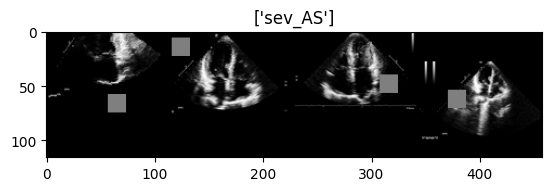

In [59]:
# Image loading code modified from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualize-a-few-images

code_to_diagnosis = ["no_AS", "mod_AS", "sev_AS"]

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
inputs = inputs.squeeze(0) # Remove singleton batch dimension to produce tensor with shape (Channels, Heigh, Width)
inputs = inputs[:4] # Select 4 images

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[code_to_diagnosis[x] for x in classes])

##   Model

The paper evaluates multiple models in addition to the SAMIL model they have contributed. These models include ABMIL and DSMIL. As mentioned previously, only ABMIL and SAMIL will be trained in this reproduction.

### Citation

@misc{huang2024detecting,
      title={Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning},
      author={Zhe Huang and Benjamin S. Wessler and Michael C. Hughes},
      year={2024},
      eprint={2306.00003},
      archivePrefix={arXiv},
      primaryClass={eess.IV}
}

### Repo Link
https://github.com/tufts-ml/SAMIL


### SAMIL Model

The SAMIL model is based on the concept of Multiple Instance Learning (MIL). With MIL, instead of labeling individual samples, you produce a "bag" or "study" of samples, and then label the entire bag. In the context of this paper, a bag represents ultrasound images from a single patient study, with a label indicating if the study showed no AS, mild to moderate AS, or severe AS.

In addition to MIL, SAMIL introduces an attention mechanism to weigh the importance of different "views" in the study - as some views are more important/informative than others (e.g., those that show an aortic valve). In this case, a "view" is a certain position of the ultrasound device around the heart. This enables the model to only consider the most relevant information from the set of images in the study.

Lastly, SAMIL introduces a supervised approach unlike other MIL approaches which are unsupervised. This means that a pretrained model is provided during training with labeled images, or labeled bags - dependent on which approach is being used. The paper introduces two types of pretraining: Bag Level and Image Level. The authors implemented this as a "View Classifier" class, and the code has been ported into this notebook.


#### SAMIL - WideResNet

When the SAMIL model is pretrained using bag-level or image-level contrastive learning, the View Classifier maps an image to the probability that it shows a relevant view of an aortic valve (either a PLAX or PSAX view) vs. another type such as A2C, A4C, A5C.

This code is pulled directly from the paper repo without modifications.

In [15]:
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)



def mish(x):
    """Mish: A Self Regularized Non-Monotonic Neural Activation Function (https://arxiv.org/abs/1908.08681)"""
    return x * torch.tanh(F.softplus(x))


class PSBatchNorm2d(nn.BatchNorm2d):
    """How Does BN Increase Collapsed Neural Network Filters? (https://arxiv.org/abs/2001.11216)"""

    def __init__(self, num_features, alpha=0.1, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True):
        super().__init__(num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, x):
        return super().forward(x) + self.alpha


class BasicBlock(nn.Module):
    def __init__(
        self,
        in_planes,
        out_planes,
        stride,
        drop_rate=0.0,
        activate_before_residual=False,
    ):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(
            in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(
            out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.drop_rate = drop_rate
        self.equalInOut = in_planes == out_planes
        self.convShortcut = (
            (not self.equalInOut)
            and nn.Conv2d(
                in_planes,
                out_planes,
                kernel_size=1,
                stride=stride,
                padding=0,
                bias=False,
            )
            or None
        )
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(
        self,
        nb_layers,
        in_planes,
        out_planes,
        block,
        stride,
        drop_rate=0.0,
        activate_before_residual=False,
    ):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block,
            in_planes,
            out_planes,
            nb_layers,
            stride,
            drop_rate,
            activate_before_residual,
        )

    def _make_layer(
        self,
        block,
        in_planes,
        out_planes,
        nb_layers,
        stride,
        drop_rate,
        activate_before_residual,
    ):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(
                block(
                    i == 0 and in_planes or out_planes,
                    out_planes,
                    i == 0 and stride or 1,
                    drop_rate,
                    activate_before_residual,
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [
            16,
            16 * widen_factor,
            32 * widen_factor,
            64 * widen_factor,
            128 * widen_factor,
        ]
        assert (depth - 4) % 6 == 0
        n = (depth - 4) / 6  # equivalent to 'repeat' in tf repo
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(
            3, channels[0], kernel_size=3, stride=1, padding=1, bias=False
        )
        # 1st block
        self.block1 = NetworkBlock(
            n,
            channels[0],
            channels[1],
            block,
            1,
            drop_rate,
            activate_before_residual=True,
        )
        # 2nd block
        self.block2 = NetworkBlock(n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(n, channels[2], channels[3], block, 2, drop_rate)

        # 4th block (hz added)
        self.block4 = NetworkBlock(n, channels[3], channels[4], block, 2, drop_rate)

        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[4], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[4], num_classes)
        self.channels = channels[4]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode="fan_out", nonlinearity="leaky_relu"
                )
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)

        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    return WideResNet(
        depth=depth,
        widen_factor=widen_factor,
        drop_rate=dropout,
        num_classes=num_classes,
    )


#### SAMIL Model

The SAMIL model has several layers, consisting of these major components:
1. A three part feature extractor consisting of a stack of convolution layers to extract features from the input images and then further process them.
2. Two parallel attention mechanisms to output attention weights with `tanh` activations for non-linearity. One attention mechanism  is for the view-classifier-supervised attention, and other is a flexible attention. This enables the freedom to focus on certain images over others.
3. Classifier layer maps the final representation of the "bag" to the output classes.

The SAMIL class is unmodified code from the paper repo.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SAMIL(nn.Module):
    def __init__(self, num_classes=3):
        super(SAMIL, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            # Below layers added in addition to original ABMIL paper
            nn.Conv2d(50, 100, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(200 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.feature_extractor_part3 = nn.Sequential(
            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.ReLU(),
        )

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D), nn.Tanh(), nn.Linear(self.D, self.K)
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D), nn.Tanh(), nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, self.num_classes),
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 200 * 4 * 4)
        H = self.feature_extractor_part2(H)

        A_V = self.attention_V(H)  # NxK
        A_V = torch.transpose(A_V, 1, 0)  # KxN
        A_V = F.softmax(A_V, dim=1)  # softmax over number of images

        H = self.feature_extractor_part3(H)

        A_U = self.attention_U(H)  # NxK
        A_U = torch.transpose(A_U, 1, 0)  # KxN
        A_U = F.softmax(A_U, dim=1)  # softmax over number of images

        A = torch.exp(
            torch.log(A_V) + torch.log(A_U)
        )  # numerically more stable softmax implementation
        A = A / torch.sum(A)

        M = torch.mm(A, H)  # KxL, M can be regarded as final representation of this bag

        out = self.classifier(M)  # Outputs logits and not softmax

        return out, A_V  # Only view regularize one branch of the attention weights

#### SAMIL Helpers
The following helper methods are from the paper's Github repo. Specifically the `src/SAMIL/main.py` file.



In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms

logger = logging.getLogger(__name__)

def save_checkpoint(state, checkpoint_dir, filename='last_checkpoint.pth.tar', write_to_gdrive=False):
    '''last_checkpoint.pth.tar or xxx_model_best.pth.tar'''

    filepath = os.path.join(checkpoint_dir, filename)
    torch.save(state, filepath)

    if write_to_gdrive:
        gd_filepath = os.path.join('/content/drive/MyDrive/SAMIL/checkpoints', filename)
        torch.save(state, gd_filepath)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_cosine_schedule_with_warmup(optimizer,
                                    lr_warmup_epochs,
                                    lr_cycle_epochs, #total train epochs
                                    num_cycles=7./16.,
                                    last_epoch=-1):
    def _lr_lambda(current_epoch):
        if current_epoch < lr_warmup_epochs:
            return float(current_epoch) / float(max(1, lr_warmup_epochs))

        #see if using restart
        ###############################################################
        if current_epoch%lr_cycle_epochs==0:
            current_cycle_epoch=lr_cycle_epochs
        else:
            current_cycle_epoch = current_epoch%lr_cycle_epochs

        no_progress = float(current_cycle_epoch - lr_warmup_epochs) / \
            float(max(1, float(lr_cycle_epochs) - lr_warmup_epochs))
        #################################################################

        return max(0., math.cos(math.pi * num_cycles * no_progress))

    return LambdaLR(optimizer, _lr_lambda, last_epoch)

def create_view_model(view_checkpoint_path=''):

    view_model = build_wideresnet(depth=28,
                                        widen_factor=2,
                                        dropout=0.0,
                                        num_classes=3)


    if view_checkpoint_path != '':
        view_checkpoint = torch.load(view_checkpoint_path)
        view_model.load_state_dict(view_checkpoint['ema_state_dict'])
        view_model.eval()

    logger.info("Total params for View Model: {:.2f}M".format(
    sum(p.numel() for p in view_model.parameters())/1e6))

    return view_model

def create_model(MIL_checkpoint_path):
    model = SAMIL()

    if MIL_checkpoint_path !='':
        print("Using checkpoint path: {}".format(MIL_checkpoint_path))
        pretrained_dict = torch.load(MIL_checkpoint_path)

        from collections import OrderedDict
        new_state_dict = OrderedDict()

        for k, v in pretrained_dict.items():
            if 'encoder_q' in k:
                name = '.'.join(k.split('.')[1:])
                new_state_dict[name] = v

        model_dict = model.state_dict()

        new_state_dict = {k: v for k, v in new_state_dict.items() if k in model_dict}
        model_dict.update(new_state_dict)

        model.load_state_dict(model_dict)

    logger.info("Total params: {:.2f}M".format(
        sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6))

    return model

### ABMIL Model

The ABMIL model is an "off-the-shelf" attention based MIL model. Compared to SAMIL, ABMIL does not utilize a pretrained view classifier, and only has a single attention mechanism (vs. the dual attention mechanism in SAMIL).

In [18]:
class Attention(nn.Module):
    def __init__(self, num_classes=3):
        super(Attention, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(50, 100, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )


        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(200 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.feature_extractor_part3 = nn.Sequential(

            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.ReLU(),
        )


        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, self.num_classes),
        )

    def forward(self, x):
        x = x.squeeze(0)
        H = self.feature_extractor_part1(x)
        H = H.view(-1, 200 * 4 * 4)
        H = self.feature_extractor_part2(H)  # NxL
        H = self.feature_extractor_part3(H) #
        A = self.attention(H)  # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N
        M = torch.mm(A, H)  # KxL #M can be regarded as final representation of this bag
        out = self.classifier(M)

        return out, A #A is the attention weights on each image of the bag

class GatedAttention(nn.Module):
    def __init__(self, num_classes=3):
        super(GatedAttention, self).__init__()
        self.L = 500
        self.B = 250
        self.D = 128
        self.K = 1
        self.num_classes = num_classes

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(50, 100, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(100, 200, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )

        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(200 * 4 * 4, self.L),
            nn.ReLU(),
        )

        self.feature_extractor_part3 = nn.Sequential(

            nn.Linear(self.L, self.B),
            nn.ReLU(),
            nn.Linear(self.B, self.L),
            nn.ReLU(),
        )


        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Sigmoid()
        )

        self.attention_weights = nn.Linear(self.D, self.K)

        self.classifier = nn.Sequential(
            nn.Linear(self.L*self.K, self.num_classes),
        )

    def forward(self, x):
        x = x.squeeze(0)

        H = self.feature_extractor_part1(x)
        H = H.view(-1, 200 * 4 * 4)
        H = self.feature_extractor_part2(H)  # NxL
        H = self.feature_extractor_part3(H)  # NxL
        A_V = self.attention_V(H)  # NxD
        A_U = self.attention_U(H)  # NxD
        A = self.attention_weights(A_V * A_U) # element wise multiplication # NxK
        A = torch.transpose(A, 1, 0)  # KxN
        A = F.softmax(A, dim=1)  # softmax over N
        M = torch.mm(A, H)  # KxL #M can be regarded as final representation of this bag
        out = self.classifier(M)


        return out, A #A is the attention weights on each image of the bag

## SAMIL Training

The method below sets up various arguments around pretraining. The paper explores three methods of training: No Pretraining, pre training the Feature Extrator (to learn instance-level representations), and pre training the study-level representations of all *K* images in a routine echocardiogram.

In [19]:
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO
)

#### Train One Epoch and Early Stop Logic

The code block below contains the methods to train a single epoch and the early stop logic.

In [20]:
from copy import deepcopy
from sklearn.metrics import balanced_accuracy_score

import torch

import time
from tqdm import tqdm
import torch.nn.functional as F

import logging
from sklearn.metrics import confusion_matrix as sklearn_cm
import numpy as np
import os
import pickle

import torch
import torch.nn as nn

import numpy as np

from sklearn.metrics import confusion_matrix as sklearn_cm


class EarlyStopping:
    """Early stops the training if validation acc doesn't improve after a given patience."""

    def __init__(self, patience=300, initial_count=0, delta=0):

        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 20
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0

        """

        self.patience = patience
        self.counter = initial_count
        self.best_score = None
        self.early_stop = False
        self.delta = delta


    def __call__(self, val_acc):

        score = val_acc

        if self.best_score is None:
            self.best_score = score

        elif score <= self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.counter = 0

        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: {}, score: {}, best_score: {}'.format(self.counter, score, self.best_score))

        return self.counter


def train_one_epoch(lambda_ViewRegularization, train_epoch, ViewRegularization_warmup_pos,T, weights, train_loader, model, view_model, optimizer, scheduler, epoch):
    model.train()
    view_model.eval()
    train_loss = 0

    for data, bag_label in tqdm(train_loader, disable=True):
        optimizer.zero_grad()

        data, bag_label = data.to(device), bag_label.to(device)

        outputs, attentions = model(data)
        outputs, attentions = outputs.to(device), attentions.to(device)

        log_attentions = torch.log(attentions)

        with torch.no_grad():
            view_predictions = view_model(data.squeeze(0))
            view_predictions = view_predictions.to(device)

            softmax_view_predictions = F.softmax(view_predictions, dim=1)

            predicted_relevance = softmax_view_predictions[:, :2]
            predicted_relevance = torch.sum(predicted_relevance, dim=1)

            predicted_relative_relevance = F.softmax(predicted_relevance/T)
            predicted_relative_relevance = predicted_relative_relevance.unsqueeze(0)


        LabeledCELoss = F.cross_entropy(outputs, bag_label, weights, reduction='mean')

        current_warmup = np.clip(epoch/(float(ViewRegularization_warmup_pos) * train_epoch), 0, 1)

        ViewRegularizationLoss = F.kl_div(input=log_attentions, target=predicted_relative_relevance, reduction='batchmean')

        total_loss = LabeledCELoss + lambda_ViewRegularization * ViewRegularizationLoss * current_warmup

        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.detach().cpu().item()

    train_loss = train_loss / len(train_loader)

    return train_loss

def eval_model(data_loader, raw_model, epoch):
    raw_model.eval()

    with torch.no_grad():
        ground_truth_labels = []
        pred_labels = []

        for data, bag_label in data_loader:
            data, bag_label = data.to(device), bag_label.to(device)

            pred_logit, _ = raw_model(data)

            pred_label = torch.softmax(pred_logit, dim=-1)
            pred_label = torch.argmax(pred_label).item()

            pred_labels.append(pred_label)
            ground_truth_labels.append(bag_label.item())

        bal_acc = balanced_accuracy_score(ground_truth_labels, pred_labels)

    return bal_acc


#### Training Runner
The code block below contains the logic to train the model, one epoch at a time, with early stop, and the logic to write the results out. This method is called in subsequent training blocks after the training arguments are defined.

In [21]:
import json

def train_samil(
    train_epoch,
    patience,
    early_stopping_warmup,
    eval_every_Xepoch,
    type,
    experiment_dir,
    weights,
    train_loader,
    val_loader,
    model,
    view_model,
    optimizer,
    scheduler,
    lambda_ViewRegularization,
    ViewRegularization_warmup_pos,
    T
):
    best_val_raw_Bacc = 0
    best_test_raw_Bacc_at_val = 0

    current_count=0

    logger.info("***** Running training *****")
    logger.info(f"  Num Epochs = {train_epoch}")
    logger.info(f"  Total optimization steps = {train_epoch * len(train_dataset)}")

    early_stopping = EarlyStopping(patience, initial_count=current_count)

    train_loss_df = pd.DataFrame(
        index=range(0, train_epoch), columns=["loss"], dtype="Float32"
    )
    val_accuracy_df = pd.DataFrame(
        index=range(0, train_epoch, eval_every_Xepoch),
        columns=["val_raw_Bacc", "test_raw_Bacc"],
        dtype="Float32",
    )

    for epoch in range(train_epoch):
        TotalTrainLoss_this_epoch = train_one_epoch(lambda_ViewRegularization, train_epoch, ViewRegularization_warmup_pos,T, weights, train_loader, model, view_model, optimizer, scheduler, epoch)
        train_loss_df.loc[epoch] = TotalTrainLoss_this_epoch
        scheduler.step()

        if epoch % eval_every_Xepoch == 0:
            val_raw_Bacc = eval_model(val_loader, model, epoch)
            val_accuracy_df.loc[[epoch], ["val_raw_Bacc"]] = val_raw_Bacc

            if val_raw_Bacc > best_val_raw_Bacc:
                best_val_raw_Bacc = val_raw_Bacc

                test_raw_Bacc = eval_model(test_loader, model, epoch)
                val_accuracy_df.loc[[epoch], ["test_raw_Bacc"]] = test_raw_Bacc

                if test_raw_Bacc > best_test_raw_Bacc_at_val:
                    best_test_raw_Bacc_at_val = test_raw_Bacc
                    save_checkpoint(model.state_dict(), experiment_dir, filename="best_samil_{}_model.pth.tar".format(type), write_to_gdrive=True)

            logger.info("Epoch: %d | Total Loss: %.2f | Balanced Accuracy: %.2f" % (epoch, TotalTrainLoss_this_epoch, val_raw_Bacc))
            logger.info('Best Balanced Accuracy Seen, validation/test: %.2f %.2f' % (best_val_raw_Bacc, best_test_raw_Bacc_at_val))

            if epoch > early_stopping_warmup:
                current_count = early_stopping(val_raw_Bacc)

            save_checkpoint(model.state_dict(), experiment_dir, filename="last_checkpoint_samil_{}.pth.tar".format(type), write_to_gdrive=True)

            if early_stopping.early_stop:
                break

    gd_csv_filepath = os.path.join('/content/drive/MyDrive/SAMIL/checkpoints/')

    train_loss_df.to_csv(
        gd_csv_filepath + "train_loss_df_{}.csv".format(type), sep=",", header=True, index=True, index_label="epoch"
    )

    val_accuracy_df.to_csv(gd_csv_filepath + "val_accuracy_df_{}.csv".format(type), sep=",", header=True, index=True, index_label="epoch")

### Hyperparameters

The final hyperparameters used by the authors are published in their Github repo here: [Hyperparameters](https://github.com/tufts-ml/SAMIL/blob/main/Hyperparameters/Hyperparameters.txt)

#### SAMIL Hyperparameters

1.   Learning rate (lr)
2.   Weight decay (wd) for regularizing the model and improving generalization.
3.   Temperature (T) scaling term to adjust the softmax output. For higher T, the softmax output becomes softer with more uniform probabilities and reduces the model's confidence across predictions of new, unseen data. A lower T results in a sharper softmax output, increasing the delta between the higher probability and other probabilities, increasing the model's confidence.
4.   Lambda View Regularization (λ<sub>sA</sub>) to balance the supervised attention loss and cross-entropy loss.

| SAMIL (with study-level SSL) | split1 | split2 | split3 |
| ---------------------------- | ------ | ------ | ------ |
| Learning rate                | 0.0008 | 0.0005 | 0.0005 |
| Weight decay                 | 0.0001 | 0.0001 | 0.001  |
| Temperature T                | 0.1    | 0.05   | 0.1    |
| λ<sub>sA</sub>               | 15.0   | 20.0   | 20.0   |
| Learning rate schedule       | cosine | cosine | cosine |

#### ABMIL Hyperparameters

| ABMIL | split1 | split2 | split3 |
| ---------------------------- | ------ | ------ | ------ |
| Learning rate                | 0.0008 | 0.0005 | 0.0008 |
| Weight decay                 | 0.0001 | 0.00005 | 0.00005  |
| Learning rate schedule       | cosine | cosine | cosine |

As a reminder, this notebook only reproduces `split1`.



### Computational Requirements

The paper reported using an Nvidia A100 GPU for all training runs. This notebook was run in Google Colab with Pro+ membership and trained using the Colab A100 at a compute unit consumption rate of ~11.77 units / hour. At a cost of ~ $1.17 USD per hour.

The following statistics were captured during the reproduction of this paper:

| Model | Avg Runtime/ Epoch | Number of Trials | GPU hrs used | # Training Epochs
| ---------------------------- | ------ | ------ | ------ | |
| ABMIL                | .08 seconds | 1 | .95 | 721 |
| SAMIL (no pretraining)                 | TK | 1 | TK  | TK |
| SAMIL (image level pretraining)                | TK    | 1   | TK    | TK |
| SAMIL (bag/study level pretraining)               | TK   | 9   | 4.5   | 705 |

Study Level: 2h 52m 26s
Epochs: 705


When reproducing the paper, SAMIL with Bag Level Pretraining was the first model trained. The paper reported a final learning rate of 0.0008, which was used to train first. This provided unfavorable results with balanced accuracy (0.65), so the learning rate was lowered to 0.0006 with marginal improvements (0.69), and finally lowered to 0.0005 providing the best balanced accuracy. This was then used for the other two SAMIL training runs.

ABMIL produced favorable results using the exact hyperparameters from the paper, so only one trial was needed.

###  No Pretraining

This block configures training the SAMIL model without any pretraining. Per the paper, the max epochs is set to 2,000 with a warmup of 200 epochs and patience of 200 epochs.

In [22]:
RUNS_DIR = '/content/runs/'

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset_randaug, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

training_seed= 0
data_seed= 0
checkpoint_dir= MODEL_CHECKPOINTS
MIL_checkpoint_path= ''
lr= 0.0005 # learning rate
wd= 0.0001 # weight decay
T= 0.1 # tempertature
lambda_ViewRegularization= 15.0 # λsA
train_dir= RUNS_DIR + 'SAMIL'
resume= 'None'
train_epoch= 2000 # number of epochs, 2000 defined in the paper. CHANGE ME!
device= device
start_epoch= 0
patience= 200
early_stopping_warmup= 200
ViewRegularization_warmup_pos= 0.4
eval_every_Xepoch= 1
experiment_type='NoPretrain'

set_seed(training_seed)
MIL_checkpoint_path = ''
view_checkpoint_path = ''

experiment_name = "{}".format(experiment_type)
experiment_dir = os.path.join(train_dir, experiment_name)
os.makedirs(experiment_dir, exist_ok=True)

weights = '0.463,0.342,0.195'
weights = [float(i) for i in weights.split(',')]
weights = torch.Tensor(weights)
weights = weights.to(device)

view_model = create_view_model(view_checkpoint_path).to(device)

model = create_model(MIL_checkpoint_path).to(device)

no_decay = {'bias', 'bn'}
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': wd},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = optim.SGD(grouped_parameters, lr=lr, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, train_epoch)

train_samil(
    train_epoch,
    patience,
    early_stopping_warmup,
    eval_every_Xepoch,
    experiment_type,
    experiment_dir,
    weights,
    train_loader,
    val_loader,
    model,
    view_model,
    optimizer,
    scheduler,
    lambda_ViewRegularization,
    ViewRegularization_warmup_pos,
    T
)

INFO:__main__:Total params for View Model: 5.93M
INFO:__main__:Total params: 2.31M
INFO:__main__:***** Running training *****
INFO:__main__:  Num Epochs = 2000
INFO:__main__:  Total optimization steps = 720000


KeyboardInterrupt: 

### Image-Level Pre Training

This block configures training the SAMIL model with Image Level pretraining. Per the paper, the max epochs is set to 2,000 with a warmup of 200 epochs and patient of 200 epochs.

The `MIL_checkpoint_path` and `view_checkpoint_path` point to the appropriate model for this ablation.

In [ ]:
RUNS_DIR = '/content/runs/'

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset_randaug, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

training_seed= 0
data_seed= 0
checkpoint_dir= MODEL_CHECKPOINTS
MIL_checkpoint_path= ''
lr= 0.0005 # learning rate
wd= 0.0001 # weight decay
T= 0.1 # tempertature
lambda_ViewRegularization= 15.0 # λsA
train_dir= RUNS_DIR + 'SAMIL'
resume= 'None'
train_epoch= 2000 # number of epochs, 2000 defined in the paper. CHANGE ME!
device= device
start_epoch= 0
patience= 200
early_stopping_warmup= 200
ViewRegularization_warmup_pos= 0.4
eval_every_Xepoch= 1
experiment_type='ImageLevel'

set_seed(training_seed)
MIL_checkpoint_path = os.path.join(checkpoint_dir,'MOCO_Pretraining_ImageLevel', 'seed0_checkpoint.pt')
view_checkpoint_path = os.path.join(checkpoint_dir, 'view_classifier', 'seed0_model_best.pth.tar')

experiment_name = "{}".format(experiment_type)
experiment_dir = os.path.join(train_dir, experiment_name)
os.makedirs(experiment_dir, exist_ok=True)

weights = '0.463,0.342,0.195'
weights = [float(i) for i in weights.split(',')]
weights = torch.Tensor(weights)
weights = weights.to(device)

view_model = create_view_model(view_checkpoint_path).to(device)

model = create_model(MIL_checkpoint_path).to(device)

no_decay = {'bias', 'bn'}
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': wd},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = optim.SGD(grouped_parameters, lr=lr, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, train_epoch)

train_samil(
    train_epoch,
    patience,
    early_stopping_warmup,
    eval_every_Xepoch,
    experiment_type,
    experiment_dir,
    weights,
    train_loader,
    val_loader,
    model,
    view_model,
    optimizer,
    scheduler,
    lambda_ViewRegularization,
    ViewRegularization_warmup_pos,
    T
)

### Bag-Level (Study Level) Pre Training

This block configures training the SAMIL model with Bag (Study) Level pretraining. Per the paper, the max epochs is set to 2,000 with a warmup of 200 epochs and patient of 200 epochs.

The MIL_checkpoint_path and view_checkpoint_path point to the appropriate model for this ablation.

In [60]:
RUNS_DIR = '/content/runs/'

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset_randaug, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

training_seed= 0
data_seed= 0
checkpoint_dir= MODEL_CHECKPOINTS
MIL_checkpoint_path= ''
lr= 0.0005 # learning rate
wd= 0.0001 # weight decay
T= 0.1 # tempertature
lambda_ViewRegularization= 15.0 # λsA
train_dir= RUNS_DIR + 'SAMIL'
resume= 'None'
train_epoch= 2000 # number of epochs, 2000 defined in the paper. CHANGE ME!
device= device
start_epoch= 0
patience= 200
early_stopping_warmup= 200
ViewRegularization_warmup_pos= 0.4
eval_every_Xepoch= 1
experiment_type='StudyLevel'

set_seed(training_seed)
MIL_checkpoint_path = os.path.join(checkpoint_dir,'MOCO_Pretraining_StudyLevel', 'seed0_checkpoint.pt')
view_checkpoint_path = os.path.join(checkpoint_dir, 'view_classifier', 'seed0_model_best.pth.tar')

experiment_name = "{}".format(experiment_type)
experiment_dir = os.path.join(train_dir, experiment_name)
os.makedirs(experiment_dir, exist_ok=True)

weights = '0.463,0.342,0.195'
weights = [float(i) for i in weights.split(',')]
weights = torch.Tensor(weights)
weights = weights.to(device)

view_model = create_view_model(view_checkpoint_path).to(device)

model = create_model(MIL_checkpoint_path).to(device)

no_decay = {'bias', 'bn'}
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': wd},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = optim.SGD(grouped_parameters, lr=lr, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, train_epoch)

train_samil(
    train_epoch,
    patience,
    early_stopping_warmup,
    eval_every_Xepoch,
    experiment_type,
    experiment_dir,
    weights,
    train_loader,
    val_loader,
    model,
    view_model,
    optimizer,
    scheduler,
    lambda_ViewRegularization,
    ViewRegularization_warmup_pos,
    T
)

INFO:__main__:Total params for View Model: 5.93M
INFO:__main__:Total params: 2.31M
INFO:__main__:***** Running training *****
INFO:__main__:  Num Epochs = 2000
INFO:__main__:  Total optimization steps = 720000


Using checkpoint path: /content/model_checkpoints/MOCO_Pretraining_StudyLevel/seed0_checkpoint.pt


INFO:__main__:Epoch: 0 | Total Loss: 1.09 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 1 | Total Loss: 1.08 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 2 | Total Loss: 1.10 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 3 | Total Loss: 1.12 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 4 | Total Loss: 1.14 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 5 | Total Loss: 1.16 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 6 | Total Loss: 1.18 | Balanced Accuracy: 0.44
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.44 0.47
INFO:__main__:Epoch: 7 | Total Los

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.5034640522875817, best_score: 0.5034640522875817


INFO:__main__:Epoch: 202 | Total Loss: 0.73 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.6716993464052288, best_score: 0.6716993464052288


INFO:__main__:Epoch: 203 | Total Loss: 0.70 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.6498692810457517, best_score: 0.6716993464052288


INFO:__main__:Epoch: 204 | Total Loss: 0.72 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.6094117647058823, best_score: 0.6716993464052288


INFO:__main__:Epoch: 205 | Total Loss: 0.74 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.6718954248366013, best_score: 0.6718954248366013


INFO:__main__:Epoch: 206 | Total Loss: 0.67 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.5577124183006537, best_score: 0.6718954248366013


INFO:__main__:Epoch: 207 | Total Loss: 0.78 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.6398039215686274, best_score: 0.6718954248366013


INFO:__main__:Epoch: 208 | Total Loss: 0.74 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.643921568627451, best_score: 0.6718954248366013


INFO:__main__:Epoch: 209 | Total Loss: 0.73 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.5505228758169936, best_score: 0.6718954248366013


INFO:__main__:Epoch: 210 | Total Loss: 0.74 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.6504575163398694, best_score: 0.6718954248366013


INFO:__main__:Epoch: 211 | Total Loss: 0.63 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.574640522875817, best_score: 0.6718954248366013


INFO:__main__:Epoch: 212 | Total Loss: 0.66 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.574640522875817, best_score: 0.6718954248366013


INFO:__main__:Epoch: 213 | Total Loss: 0.74 | Balanced Accuracy: 0.49
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.4886274509803921, best_score: 0.6718954248366013


INFO:__main__:Epoch: 214 | Total Loss: 0.72 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.529607843137255, best_score: 0.6718954248366013


INFO:__main__:Epoch: 215 | Total Loss: 0.76 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 10, score: 0.6034640522875817, best_score: 0.6718954248366013


Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0>
Exception ignored in: Exception ignored in: Traceback (most recent call last):

<function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0><function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0>Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in: 

Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d81802ce0e0>    Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 11, score: 0.6483660130718955, best_score: 0.6718954248366013


INFO:__main__:Epoch: 217 | Total Loss: 0.75 | Balanced Accuracy: 0.47
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 12, score: 0.47169934640522876, best_score: 0.6718954248366013


INFO:__main__:Epoch: 218 | Total Loss: 0.69 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 13, score: 0.6432679738562092, best_score: 0.6718954248366013


INFO:__main__:Epoch: 219 | Total Loss: 0.69 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.689673202614379, best_score: 0.689673202614379


INFO:__main__:Epoch: 220 | Total Loss: 0.61 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.5608496732026144, best_score: 0.689673202614379


INFO:__main__:Epoch: 221 | Total Loss: 0.64 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.6596732026143791, best_score: 0.689673202614379


INFO:__main__:Epoch: 222 | Total Loss: 0.76 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.6080392156862745, best_score: 0.689673202614379


INFO:__main__:Epoch: 223 | Total Loss: 0.70 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.5984967320261437, best_score: 0.689673202614379


INFO:__main__:Epoch: 224 | Total Loss: 0.72 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.5997385620915033, best_score: 0.689673202614379


INFO:__main__:Epoch: 225 | Total Loss: 0.65 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6079738562091502, best_score: 0.689673202614379


INFO:__main__:Epoch: 226 | Total Loss: 0.74 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.6416339869281046, best_score: 0.689673202614379


INFO:__main__:Epoch: 227 | Total Loss: 0.74 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.5526797385620915, best_score: 0.689673202614379


INFO:__main__:Epoch: 228 | Total Loss: 0.64 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.5301960784313725, best_score: 0.689673202614379


INFO:__main__:Epoch: 229 | Total Loss: 0.73 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 10, score: 0.6693464052287581, best_score: 0.689673202614379


INFO:__main__:Epoch: 230 | Total Loss: 0.75 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 11, score: 0.67718954248366, best_score: 0.689673202614379


INFO:__main__:Epoch: 231 | Total Loss: 0.68 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 12, score: 0.5513071895424836, best_score: 0.689673202614379


INFO:__main__:Epoch: 232 | Total Loss: 0.67 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 13, score: 0.6058169934640523, best_score: 0.689673202614379


INFO:__main__:Epoch: 233 | Total Loss: 0.69 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 14, score: 0.6341176470588236, best_score: 0.689673202614379


INFO:__main__:Epoch: 234 | Total Loss: 0.79 | Balanced Accuracy: 0.52
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 15, score: 0.5169281045751634, best_score: 0.689673202614379


INFO:__main__:Epoch: 235 | Total Loss: 0.66 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 16, score: 0.66, best_score: 0.689673202614379


INFO:__main__:Epoch: 236 | Total Loss: 0.69 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 17, score: 0.6725490196078431, best_score: 0.689673202614379


INFO:__main__:Epoch: 237 | Total Loss: 0.70 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.694640522875817, best_score: 0.694640522875817


INFO:__main__:Epoch: 238 | Total Loss: 0.73 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.5343790849673203, best_score: 0.694640522875817


INFO:__main__:Epoch: 239 | Total Loss: 0.60 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.6274509803921569, best_score: 0.694640522875817


INFO:__main__:Epoch: 240 | Total Loss: 0.67 | Balanced Accuracy: 0.50
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.497843137254902, best_score: 0.694640522875817


INFO:__main__:Epoch: 241 | Total Loss: 0.73 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.6284313725490196, best_score: 0.694640522875817


INFO:__main__:Epoch: 242 | Total Loss: 0.68 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.6685620915032678, best_score: 0.694640522875817


INFO:__main__:Epoch: 243 | Total Loss: 0.62 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6341176470588236, best_score: 0.694640522875817


INFO:__main__:Epoch: 244 | Total Loss: 0.73 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.6557516339869282, best_score: 0.694640522875817


INFO:__main__:Epoch: 245 | Total Loss: 0.76 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.5996732026143791, best_score: 0.694640522875817


INFO:__main__:Epoch: 246 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.6686928104575164, best_score: 0.694640522875817


INFO:__main__:Epoch: 247 | Total Loss: 0.65 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 10, score: 0.6386928104575164, best_score: 0.694640522875817


INFO:__main__:Epoch: 248 | Total Loss: 0.69 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 11, score: 0.5715032679738562, best_score: 0.694640522875817


INFO:__main__:Epoch: 249 | Total Loss: 0.67 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 12, score: 0.65640522875817, best_score: 0.694640522875817


INFO:__main__:Epoch: 250 | Total Loss: 0.74 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 13, score: 0.6024183006535947, best_score: 0.694640522875817


INFO:__main__:Epoch: 251 | Total Loss: 0.73 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 14, score: 0.6323529411764706, best_score: 0.694640522875817


INFO:__main__:Epoch: 252 | Total Loss: 0.66 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 15, score: 0.5859477124183007, best_score: 0.694640522875817


INFO:__main__:Epoch: 253 | Total Loss: 0.63 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 16, score: 0.6252287581699346, best_score: 0.694640522875817


INFO:__main__:Epoch: 254 | Total Loss: 0.64 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 17, score: 0.6716339869281045, best_score: 0.694640522875817


INFO:__main__:Epoch: 255 | Total Loss: 0.62 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 18, score: 0.6447058823529411, best_score: 0.694640522875817


INFO:__main__:Epoch: 256 | Total Loss: 0.64 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 19, score: 0.5879738562091504, best_score: 0.694640522875817


INFO:__main__:Epoch: 257 | Total Loss: 0.63 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 20, score: 0.5386274509803922, best_score: 0.694640522875817


INFO:__main__:Epoch: 258 | Total Loss: 0.57 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 21, score: 0.6027450980392157, best_score: 0.694640522875817


INFO:__main__:Epoch: 259 | Total Loss: 0.78 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 22, score: 0.6606535947712419, best_score: 0.694640522875817


INFO:__main__:Epoch: 260 | Total Loss: 0.66 | Balanced Accuracy: 0.47
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 23, score: 0.4694771241830065, best_score: 0.694640522875817


INFO:__main__:Epoch: 261 | Total Loss: 0.67 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 24, score: 0.6288888888888889, best_score: 0.694640522875817


INFO:__main__:Epoch: 262 | Total Loss: 0.61 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 25, score: 0.5796078431372549, best_score: 0.694640522875817


INFO:__main__:Epoch: 263 | Total Loss: 0.62 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 26, score: 0.5964705882352941, best_score: 0.694640522875817


INFO:__main__:Epoch: 264 | Total Loss: 0.58 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 27, score: 0.5590196078431373, best_score: 0.694640522875817


INFO:__main__:Epoch: 265 | Total Loss: 0.68 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 28, score: 0.6330065359477124, best_score: 0.694640522875817


INFO:__main__:Epoch: 266 | Total Loss: 0.72 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 29, score: 0.5897385620915033, best_score: 0.694640522875817


INFO:__main__:Epoch: 267 | Total Loss: 0.75 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 30, score: 0.6635947712418301, best_score: 0.694640522875817


INFO:__main__:Epoch: 268 | Total Loss: 0.72 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 31, score: 0.5913725490196079, best_score: 0.694640522875817


INFO:__main__:Epoch: 269 | Total Loss: 0.65 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 32, score: 0.6587581699346404, best_score: 0.694640522875817


INFO:__main__:Epoch: 270 | Total Loss: 0.61 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 33, score: 0.5415032679738562, best_score: 0.694640522875817


INFO:__main__:Epoch: 271 | Total Loss: 0.64 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 34, score: 0.6577124183006536, best_score: 0.694640522875817


INFO:__main__:Epoch: 272 | Total Loss: 0.65 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 35, score: 0.5822222222222222, best_score: 0.694640522875817


INFO:__main__:Epoch: 273 | Total Loss: 0.60 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 36, score: 0.5970588235294118, best_score: 0.694640522875817


INFO:__main__:Epoch: 274 | Total Loss: 0.56 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 37, score: 0.6487581699346405, best_score: 0.694640522875817


INFO:__main__:Epoch: 275 | Total Loss: 0.62 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 38, score: 0.6087581699346405, best_score: 0.694640522875817


INFO:__main__:Epoch: 276 | Total Loss: 0.67 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 39, score: 0.5681699346405229, best_score: 0.694640522875817


INFO:__main__:Epoch: 277 | Total Loss: 0.62 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 40, score: 0.5954901960784315, best_score: 0.694640522875817


INFO:__main__:Epoch: 278 | Total Loss: 0.62 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 41, score: 0.5322875816993464, best_score: 0.694640522875817


INFO:__main__:Epoch: 279 | Total Loss: 0.60 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 42, score: 0.5933986928104575, best_score: 0.694640522875817


INFO:__main__:Epoch: 280 | Total Loss: 0.74 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 43, score: 0.5406535947712419, best_score: 0.694640522875817


INFO:__main__:Epoch: 281 | Total Loss: 0.58 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 44, score: 0.5775816993464052, best_score: 0.694640522875817


INFO:__main__:Epoch: 282 | Total Loss: 0.62 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 45, score: 0.6333333333333334, best_score: 0.694640522875817


INFO:__main__:Epoch: 283 | Total Loss: 0.59 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 46, score: 0.5837254901960784, best_score: 0.694640522875817


INFO:__main__:Epoch: 284 | Total Loss: 0.72 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 47, score: 0.5809803921568627, best_score: 0.694640522875817


INFO:__main__:Epoch: 285 | Total Loss: 0.72 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 48, score: 0.6589542483660131, best_score: 0.694640522875817


INFO:__main__:Epoch: 286 | Total Loss: 0.68 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 49, score: 0.6265359477124184, best_score: 0.694640522875817


INFO:__main__:Epoch: 287 | Total Loss: 0.86 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 50, score: 0.6633333333333332, best_score: 0.694640522875817


INFO:__main__:Epoch: 288 | Total Loss: 0.75 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 51, score: 0.6350326797385621, best_score: 0.694640522875817


INFO:__main__:Epoch: 289 | Total Loss: 0.58 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 52, score: 0.6510457516339869, best_score: 0.694640522875817


INFO:__main__:Epoch: 290 | Total Loss: 0.66 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 53, score: 0.5581045751633987, best_score: 0.694640522875817


INFO:__main__:Epoch: 291 | Total Loss: 0.76 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 54, score: 0.6559477124183006, best_score: 0.694640522875817


INFO:__main__:Epoch: 292 | Total Loss: 0.61 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 55, score: 0.6615032679738562, best_score: 0.694640522875817


INFO:__main__:Epoch: 293 | Total Loss: 0.58 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 56, score: 0.6041176470588235, best_score: 0.694640522875817


INFO:__main__:Epoch: 294 | Total Loss: 0.74 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 57, score: 0.6158169934640524, best_score: 0.694640522875817


INFO:__main__:Epoch: 295 | Total Loss: 0.61 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 58, score: 0.6418954248366013, best_score: 0.694640522875817


INFO:__main__:Epoch: 296 | Total Loss: 0.63 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 59, score: 0.5703921568627451, best_score: 0.694640522875817


INFO:__main__:Epoch: 297 | Total Loss: 0.61 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 60, score: 0.6027450980392157, best_score: 0.694640522875817


INFO:__main__:Epoch: 298 | Total Loss: 0.66 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 61, score: 0.6877777777777778, best_score: 0.694640522875817


INFO:__main__:Epoch: 299 | Total Loss: 0.70 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 62, score: 0.5545751633986928, best_score: 0.694640522875817


INFO:__main__:Epoch: 300 | Total Loss: 0.63 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 63, score: 0.5824183006535949, best_score: 0.694640522875817


INFO:__main__:Epoch: 301 | Total Loss: 0.57 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 64, score: 0.6115686274509805, best_score: 0.694640522875817


INFO:__main__:Epoch: 302 | Total Loss: 0.69 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 65, score: 0.6083660130718954, best_score: 0.694640522875817


INFO:__main__:Epoch: 303 | Total Loss: 0.62 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 66, score: 0.6311764705882353, best_score: 0.694640522875817


INFO:__main__:Epoch: 304 | Total Loss: 0.91 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 67, score: 0.6326797385620915, best_score: 0.694640522875817


INFO:__main__:Epoch: 305 | Total Loss: 0.61 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 68, score: 0.5434640522875817, best_score: 0.694640522875817


INFO:__main__:Epoch: 306 | Total Loss: 0.62 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 69, score: 0.6281045751633987, best_score: 0.694640522875817


INFO:__main__:Epoch: 307 | Total Loss: 0.62 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 70, score: 0.6291503267973857, best_score: 0.694640522875817


INFO:__main__:Epoch: 308 | Total Loss: 0.62 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 71, score: 0.6035294117647059, best_score: 0.694640522875817


INFO:__main__:Epoch: 309 | Total Loss: 0.65 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 72, score: 0.5321568627450981, best_score: 0.694640522875817


INFO:__main__:Epoch: 310 | Total Loss: 0.58 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 73, score: 0.5913725490196079, best_score: 0.694640522875817


INFO:__main__:Epoch: 311 | Total Loss: 0.53 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 74, score: 0.628562091503268, best_score: 0.694640522875817


INFO:__main__:Epoch: 312 | Total Loss: 0.54 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 75, score: 0.6256209150326798, best_score: 0.694640522875817


INFO:__main__:Epoch: 313 | Total Loss: 0.64 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 76, score: 0.6567320261437909, best_score: 0.694640522875817


INFO:__main__:Epoch: 314 | Total Loss: 0.59 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 77, score: 0.6370588235294118, best_score: 0.694640522875817


INFO:__main__:Epoch: 315 | Total Loss: 0.57 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 78, score: 0.6833333333333332, best_score: 0.694640522875817


INFO:__main__:Epoch: 316 | Total Loss: 0.59 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 79, score: 0.6498692810457517, best_score: 0.694640522875817


INFO:__main__:Epoch: 317 | Total Loss: 0.62 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 80, score: 0.6827450980392156, best_score: 0.694640522875817


INFO:__main__:Epoch: 318 | Total Loss: 0.64 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 81, score: 0.646797385620915, best_score: 0.694640522875817


INFO:__main__:Epoch: 319 | Total Loss: 0.64 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 82, score: 0.6464705882352941, best_score: 0.694640522875817


INFO:__main__:Epoch: 320 | Total Loss: 0.59 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 83, score: 0.6282352941176471, best_score: 0.694640522875817


INFO:__main__:Epoch: 321 | Total Loss: 0.57 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 84, score: 0.6042483660130719, best_score: 0.694640522875817


INFO:__main__:Epoch: 322 | Total Loss: 0.65 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 85, score: 0.6141176470588235, best_score: 0.694640522875817


INFO:__main__:Epoch: 323 | Total Loss: 0.60 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 86, score: 0.5904575163398693, best_score: 0.694640522875817


INFO:__main__:Epoch: 324 | Total Loss: 0.69 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 87, score: 0.6525490196078432, best_score: 0.694640522875817


INFO:__main__:Epoch: 325 | Total Loss: 0.60 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 88, score: 0.64, best_score: 0.694640522875817


INFO:__main__:Epoch: 326 | Total Loss: 0.55 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 89, score: 0.6254901960784314, best_score: 0.694640522875817


INFO:__main__:Epoch: 327 | Total Loss: 0.59 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 90, score: 0.6779738562091504, best_score: 0.694640522875817


INFO:__main__:Epoch: 328 | Total Loss: 0.64 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 91, score: 0.6413071895424837, best_score: 0.694640522875817


INFO:__main__:Epoch: 329 | Total Loss: 0.61 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 92, score: 0.6335947712418301, best_score: 0.694640522875817


INFO:__main__:Epoch: 330 | Total Loss: 0.69 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 93, score: 0.6239869281045752, best_score: 0.694640522875817


INFO:__main__:Epoch: 331 | Total Loss: 0.68 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 94, score: 0.6520261437908497, best_score: 0.694640522875817


INFO:__main__:Epoch: 332 | Total Loss: 0.70 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 95, score: 0.6688235294117647, best_score: 0.694640522875817


INFO:__main__:Epoch: 333 | Total Loss: 0.67 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 96, score: 0.6444444444444445, best_score: 0.694640522875817


INFO:__main__:Epoch: 334 | Total Loss: 0.64 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 97, score: 0.6490849673202614, best_score: 0.694640522875817


INFO:__main__:Epoch: 335 | Total Loss: 0.64 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 98, score: 0.5882352941176471, best_score: 0.694640522875817


INFO:__main__:Epoch: 336 | Total Loss: 0.60 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 99, score: 0.603202614379085, best_score: 0.694640522875817


INFO:__main__:Epoch: 337 | Total Loss: 0.52 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 100, score: 0.6363398692810458, best_score: 0.694640522875817


INFO:__main__:Epoch: 338 | Total Loss: 0.52 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 101, score: 0.6363398692810458, best_score: 0.694640522875817


INFO:__main__:Epoch: 339 | Total Loss: 0.59 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 102, score: 0.6233333333333334, best_score: 0.694640522875817


INFO:__main__:Epoch: 340 | Total Loss: 0.60 | Balanced Accuracy: 0.51
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 103, score: 0.5136601307189542, best_score: 0.694640522875817


INFO:__main__:Epoch: 341 | Total Loss: 0.66 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 104, score: 0.6172549019607844, best_score: 0.694640522875817


INFO:__main__:Epoch: 342 | Total Loss: 0.58 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 105, score: 0.6040522875816993, best_score: 0.694640522875817


INFO:__main__:Epoch: 343 | Total Loss: 0.63 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 106, score: 0.6262091503267974, best_score: 0.694640522875817


INFO:__main__:Epoch: 344 | Total Loss: 0.64 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 107, score: 0.5406535947712419, best_score: 0.694640522875817


INFO:__main__:Epoch: 345 | Total Loss: 0.58 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 108, score: 0.6115032679738562, best_score: 0.694640522875817


INFO:__main__:Epoch: 346 | Total Loss: 0.65 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 109, score: 0.5877777777777777, best_score: 0.694640522875817


INFO:__main__:Epoch: 347 | Total Loss: 0.54 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 110, score: 0.5715032679738562, best_score: 0.694640522875817


INFO:__main__:Epoch: 348 | Total Loss: 0.58 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 111, score: 0.6079084967320262, best_score: 0.694640522875817


INFO:__main__:Epoch: 349 | Total Loss: 0.69 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 112, score: 0.6173856209150327, best_score: 0.694640522875817


INFO:__main__:Epoch: 350 | Total Loss: 0.55 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 113, score: 0.6011764705882353, best_score: 0.694640522875817


INFO:__main__:Epoch: 351 | Total Loss: 0.60 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 114, score: 0.666078431372549, best_score: 0.694640522875817


INFO:__main__:Epoch: 352 | Total Loss: 0.55 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 115, score: 0.6807189542483659, best_score: 0.694640522875817


INFO:__main__:Epoch: 353 | Total Loss: 0.59 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 116, score: 0.6167320261437909, best_score: 0.694640522875817


INFO:__main__:Epoch: 354 | Total Loss: 0.61 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 117, score: 0.608954248366013, best_score: 0.694640522875817


INFO:__main__:Epoch: 355 | Total Loss: 0.60 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 118, score: 0.6766666666666666, best_score: 0.694640522875817


INFO:__main__:Epoch: 356 | Total Loss: 0.58 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 119, score: 0.6652287581699347, best_score: 0.694640522875817


INFO:__main__:Epoch: 357 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 120, score: 0.6707843137254902, best_score: 0.694640522875817


INFO:__main__:Epoch: 358 | Total Loss: 0.57 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 121, score: 0.6496732026143791, best_score: 0.694640522875817


INFO:__main__:Epoch: 359 | Total Loss: 0.52 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 122, score: 0.6518300653594772, best_score: 0.694640522875817


INFO:__main__:Epoch: 360 | Total Loss: 0.62 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 123, score: 0.6518954248366012, best_score: 0.694640522875817


INFO:__main__:Epoch: 361 | Total Loss: 0.63 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 124, score: 0.6628758169934641, best_score: 0.694640522875817


INFO:__main__:Epoch: 362 | Total Loss: 0.71 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 125, score: 0.6573202614379084, best_score: 0.694640522875817


INFO:__main__:Epoch: 363 | Total Loss: 0.64 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 126, score: 0.6429411764705882, best_score: 0.694640522875817


INFO:__main__:Epoch: 364 | Total Loss: 0.65 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 127, score: 0.6028104575163399, best_score: 0.694640522875817


INFO:__main__:Epoch: 365 | Total Loss: 0.85 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 128, score: 0.6647712418300654, best_score: 0.694640522875817


INFO:__main__:Epoch: 366 | Total Loss: 0.63 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 129, score: 0.6711111111111111, best_score: 0.694640522875817


INFO:__main__:Epoch: 367 | Total Loss: 0.58 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 130, score: 0.62640522875817, best_score: 0.694640522875817


INFO:__main__:Epoch: 368 | Total Loss: 0.61 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 131, score: 0.6855555555555556, best_score: 0.694640522875817


INFO:__main__:Epoch: 369 | Total Loss: 0.60 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 132, score: 0.6743137254901961, best_score: 0.694640522875817


INFO:__main__:Epoch: 370 | Total Loss: 0.76 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.7188235294117648, best_score: 0.7188235294117648


INFO:__main__:Epoch: 371 | Total Loss: 0.58 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.6854248366013072, best_score: 0.7188235294117648


INFO:__main__:Epoch: 372 | Total Loss: 0.54 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.6343137254901962, best_score: 0.7188235294117648


INFO:__main__:Epoch: 373 | Total Loss: 0.66 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.6552287581699346, best_score: 0.7188235294117648


INFO:__main__:Epoch: 374 | Total Loss: 0.60 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.6818954248366013, best_score: 0.7188235294117648


INFO:__main__:Epoch: 375 | Total Loss: 0.54 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.6798039215686275, best_score: 0.7188235294117648


INFO:__main__:Epoch: 376 | Total Loss: 0.59 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6530065359477124, best_score: 0.7188235294117648


INFO:__main__:Epoch: 377 | Total Loss: 0.64 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.6434640522875817, best_score: 0.7188235294117648


INFO:__main__:Epoch: 378 | Total Loss: 0.83 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.6847712418300653, best_score: 0.7188235294117648


INFO:__main__:Epoch: 379 | Total Loss: 0.69 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.7145751633986928, best_score: 0.7188235294117648


INFO:__main__:Epoch: 380 | Total Loss: 0.67 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 10, score: 0.6289542483660131, best_score: 0.7188235294117648


INFO:__main__:Epoch: 381 | Total Loss: 0.63 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 11, score: 0.5453594771241831, best_score: 0.7188235294117648


INFO:__main__:Epoch: 382 | Total Loss: 0.68 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 12, score: 0.6304575163398692, best_score: 0.7188235294117648


INFO:__main__:Epoch: 383 | Total Loss: 0.56 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 13, score: 0.603202614379085, best_score: 0.7188235294117648


INFO:__main__:Epoch: 384 | Total Loss: 0.59 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 14, score: 0.6384313725490196, best_score: 0.7188235294117648


INFO:__main__:Epoch: 385 | Total Loss: 0.64 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 15, score: 0.6167973856209151, best_score: 0.7188235294117648


INFO:__main__:Epoch: 386 | Total Loss: 0.59 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 16, score: 0.6291503267973857, best_score: 0.7188235294117648


INFO:__main__:Epoch: 387 | Total Loss: 0.60 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 17, score: 0.6213725490196079, best_score: 0.7188235294117648


INFO:__main__:Epoch: 388 | Total Loss: 0.66 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 18, score: 0.5715686274509805, best_score: 0.7188235294117648


INFO:__main__:Epoch: 389 | Total Loss: 0.74 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 19, score: 0.5869281045751634, best_score: 0.7188235294117648


INFO:__main__:Epoch: 390 | Total Loss: 0.63 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 20, score: 0.6061437908496732, best_score: 0.7188235294117648


INFO:__main__:Epoch: 391 | Total Loss: 0.53 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 21, score: 0.690718954248366, best_score: 0.7188235294117648


INFO:__main__:Epoch: 392 | Total Loss: 0.59 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 22, score: 0.7018300653594771, best_score: 0.7188235294117648


INFO:__main__:Epoch: 393 | Total Loss: 0.61 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 23, score: 0.6729411764705882, best_score: 0.7188235294117648


INFO:__main__:Epoch: 394 | Total Loss: 0.63 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 24, score: 0.6172549019607844, best_score: 0.7188235294117648


INFO:__main__:Epoch: 395 | Total Loss: 0.64 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 25, score: 0.6574509803921568, best_score: 0.7188235294117648


INFO:__main__:Epoch: 396 | Total Loss: 0.61 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 26, score: 0.5765359477124183, best_score: 0.7188235294117648


INFO:__main__:Epoch: 397 | Total Loss: 0.58 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 27, score: 0.6315686274509804, best_score: 0.7188235294117648


INFO:__main__:Epoch: 398 | Total Loss: 0.67 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 28, score: 0.6544444444444445, best_score: 0.7188235294117648


INFO:__main__:Epoch: 399 | Total Loss: 0.70 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 29, score: 0.5654901960784314, best_score: 0.7188235294117648


INFO:__main__:Epoch: 400 | Total Loss: 0.63 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 30, score: 0.569673202614379, best_score: 0.7188235294117648


INFO:__main__:Epoch: 401 | Total Loss: 0.64 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 31, score: 0.5737908496732026, best_score: 0.7188235294117648


INFO:__main__:Epoch: 402 | Total Loss: 0.60 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 32, score: 0.6007189542483661, best_score: 0.7188235294117648


INFO:__main__:Epoch: 403 | Total Loss: 0.63 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 33, score: 0.6194771241830065, best_score: 0.7188235294117648


INFO:__main__:Epoch: 404 | Total Loss: 0.54 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 34, score: 0.7023529411764707, best_score: 0.7188235294117648


INFO:__main__:Epoch: 405 | Total Loss: 0.67 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 35, score: 0.6132026143790851, best_score: 0.7188235294117648


INFO:__main__:Epoch: 406 | Total Loss: 0.76 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 36, score: 0.5575816993464052, best_score: 0.7188235294117648


INFO:__main__:Epoch: 407 | Total Loss: 0.64 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 37, score: 0.5849019607843138, best_score: 0.7188235294117648


INFO:__main__:Epoch: 408 | Total Loss: 0.67 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 38, score: 0.6220915032679738, best_score: 0.7188235294117648


INFO:__main__:Epoch: 409 | Total Loss: 0.66 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 39, score: 0.6051633986928104, best_score: 0.7188235294117648


INFO:__main__:Epoch: 410 | Total Loss: 0.76 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 40, score: 0.6579084967320262, best_score: 0.7188235294117648


INFO:__main__:Epoch: 411 | Total Loss: 0.59 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 41, score: 0.6640522875816993, best_score: 0.7188235294117648


INFO:__main__:Epoch: 412 | Total Loss: 0.64 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 42, score: 0.6829411764705883, best_score: 0.7188235294117648


INFO:__main__:Epoch: 413 | Total Loss: 0.67 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 43, score: 0.6305882352941177, best_score: 0.7188235294117648


INFO:__main__:Epoch: 414 | Total Loss: 0.60 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 44, score: 0.6868627450980392, best_score: 0.7188235294117648


INFO:__main__:Epoch: 415 | Total Loss: 0.54 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 45, score: 0.5826797385620915, best_score: 0.7188235294117648


INFO:__main__:Epoch: 416 | Total Loss: 0.60 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 46, score: 0.6418954248366013, best_score: 0.7188235294117648


INFO:__main__:Epoch: 417 | Total Loss: 0.56 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 47, score: 0.6600653594771242, best_score: 0.7188235294117648


INFO:__main__:Epoch: 418 | Total Loss: 0.64 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 48, score: 0.645751633986928, best_score: 0.7188235294117648


INFO:__main__:Epoch: 419 | Total Loss: 0.61 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 49, score: 0.6468627450980392, best_score: 0.7188235294117648


INFO:__main__:Epoch: 420 | Total Loss: 0.58 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 50, score: 0.6067320261437908, best_score: 0.7188235294117648


INFO:__main__:Epoch: 421 | Total Loss: 0.71 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 51, score: 0.6816993464052289, best_score: 0.7188235294117648


INFO:__main__:Epoch: 422 | Total Loss: 0.59 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 52, score: 0.6543137254901961, best_score: 0.7188235294117648


INFO:__main__:Epoch: 423 | Total Loss: 0.55 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 53, score: 0.6650326797385621, best_score: 0.7188235294117648


INFO:__main__:Epoch: 424 | Total Loss: 0.61 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 54, score: 0.6375816993464052, best_score: 0.7188235294117648


INFO:__main__:Epoch: 425 | Total Loss: 0.56 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 55, score: 0.6692810457516339, best_score: 0.7188235294117648


INFO:__main__:Epoch: 426 | Total Loss: 0.76 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 56, score: 0.6206535947712418, best_score: 0.7188235294117648


INFO:__main__:Epoch: 427 | Total Loss: 0.67 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 57, score: 0.6494771241830065, best_score: 0.7188235294117648


INFO:__main__:Epoch: 428 | Total Loss: 0.67 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 58, score: 0.5786274509803921, best_score: 0.7188235294117648


INFO:__main__:Epoch: 429 | Total Loss: 0.68 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 59, score: 0.6087581699346405, best_score: 0.7188235294117648


INFO:__main__:Epoch: 430 | Total Loss: 0.63 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 60, score: 0.5979738562091503, best_score: 0.7188235294117648


INFO:__main__:Epoch: 431 | Total Loss: 0.64 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 61, score: 0.640718954248366, best_score: 0.7188235294117648


INFO:__main__:Epoch: 432 | Total Loss: 0.59 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 62, score: 0.5741176470588235, best_score: 0.7188235294117648


INFO:__main__:Epoch: 433 | Total Loss: 0.66 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 63, score: 0.5666666666666668, best_score: 0.7188235294117648


INFO:__main__:Epoch: 434 | Total Loss: 0.68 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 64, score: 0.6430718954248366, best_score: 0.7188235294117648


INFO:__main__:Epoch: 435 | Total Loss: 0.56 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 65, score: 0.5577777777777778, best_score: 0.7188235294117648


INFO:__main__:Epoch: 436 | Total Loss: 0.65 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 66, score: 0.6415032679738563, best_score: 0.7188235294117648


INFO:__main__:Epoch: 437 | Total Loss: 0.58 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 67, score: 0.5918954248366014, best_score: 0.7188235294117648


INFO:__main__:Epoch: 438 | Total Loss: 0.61 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 68, score: 0.5737254901960784, best_score: 0.7188235294117648


INFO:__main__:Epoch: 439 | Total Loss: 0.58 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 69, score: 0.6068627450980392, best_score: 0.7188235294117648


INFO:__main__:Epoch: 440 | Total Loss: 0.64 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 70, score: 0.6469281045751635, best_score: 0.7188235294117648


INFO:__main__:Epoch: 441 | Total Loss: 0.65 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 71, score: 0.6439869281045751, best_score: 0.7188235294117648


INFO:__main__:Epoch: 442 | Total Loss: 0.66 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 72, score: 0.6905228758169933, best_score: 0.7188235294117648


INFO:__main__:Epoch: 443 | Total Loss: 0.61 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 73, score: 0.6090849673202614, best_score: 0.7188235294117648


INFO:__main__:Epoch: 444 | Total Loss: 0.57 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 74, score: 0.6379738562091503, best_score: 0.7188235294117648


INFO:__main__:Epoch: 445 | Total Loss: 0.84 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 75, score: 0.596078431372549, best_score: 0.7188235294117648


INFO:__main__:Epoch: 446 | Total Loss: 0.63 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 76, score: 0.6528104575163399, best_score: 0.7188235294117648


INFO:__main__:Epoch: 447 | Total Loss: 0.59 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 77, score: 0.6595424836601308, best_score: 0.7188235294117648


INFO:__main__:Epoch: 448 | Total Loss: 0.65 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 78, score: 0.610718954248366, best_score: 0.7188235294117648


INFO:__main__:Epoch: 449 | Total Loss: 0.64 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 79, score: 0.6760784313725491, best_score: 0.7188235294117648


INFO:__main__:Epoch: 450 | Total Loss: 0.65 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 80, score: 0.660326797385621, best_score: 0.7188235294117648


INFO:__main__:Epoch: 451 | Total Loss: 0.67 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 81, score: 0.5899346405228759, best_score: 0.7188235294117648


INFO:__main__:Epoch: 452 | Total Loss: 0.61 | Balanced Accuracy: 0.51
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 82, score: 0.5132679738562093, best_score: 0.7188235294117648


INFO:__main__:Epoch: 453 | Total Loss: 0.66 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 83, score: 0.5737254901960784, best_score: 0.7188235294117648


INFO:__main__:Epoch: 454 | Total Loss: 0.65 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 84, score: 0.5937254901960783, best_score: 0.7188235294117648


INFO:__main__:Epoch: 455 | Total Loss: 0.67 | Balanced Accuracy: 0.45
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 85, score: 0.4461437908496732, best_score: 0.7188235294117648


INFO:__main__:Epoch: 456 | Total Loss: 0.71 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 86, score: 0.6081699346405228, best_score: 0.7188235294117648


INFO:__main__:Epoch: 457 | Total Loss: 0.60 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 87, score: 0.677516339869281, best_score: 0.7188235294117648


INFO:__main__:Epoch: 458 | Total Loss: 0.67 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 88, score: 0.5506535947712418, best_score: 0.7188235294117648


INFO:__main__:Epoch: 459 | Total Loss: 0.67 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 89, score: 0.677843137254902, best_score: 0.7188235294117648


INFO:__main__:Epoch: 460 | Total Loss: 0.67 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 90, score: 0.5902614379084967, best_score: 0.7188235294117648


INFO:__main__:Epoch: 461 | Total Loss: 0.65 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 91, score: 0.6550326797385622, best_score: 0.7188235294117648


INFO:__main__:Epoch: 462 | Total Loss: 0.65 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 92, score: 0.6362091503267974, best_score: 0.7188235294117648


INFO:__main__:Epoch: 463 | Total Loss: 0.69 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 93, score: 0.649607843137255, best_score: 0.7188235294117648


INFO:__main__:Epoch: 464 | Total Loss: 0.66 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 94, score: 0.6559477124183006, best_score: 0.7188235294117648


INFO:__main__:Epoch: 465 | Total Loss: 0.61 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 95, score: 0.6358823529411765, best_score: 0.7188235294117648


INFO:__main__:Epoch: 466 | Total Loss: 0.76 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 96, score: 0.6396732026143791, best_score: 0.7188235294117648


INFO:__main__:Epoch: 467 | Total Loss: 0.74 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 97, score: 0.6550326797385622, best_score: 0.7188235294117648


INFO:__main__:Epoch: 468 | Total Loss: 0.77 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 98, score: 0.699281045751634, best_score: 0.7188235294117648


INFO:__main__:Epoch: 469 | Total Loss: 0.76 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 99, score: 0.6535294117647058, best_score: 0.7188235294117648


INFO:__main__:Epoch: 470 | Total Loss: 0.71 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 100, score: 0.6711111111111111, best_score: 0.7188235294117648


INFO:__main__:Epoch: 471 | Total Loss: 0.67 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 101, score: 0.6763398692810457, best_score: 0.7188235294117648


INFO:__main__:Epoch: 472 | Total Loss: 0.67 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 102, score: 0.6530065359477124, best_score: 0.7188235294117648


INFO:__main__:Epoch: 473 | Total Loss: 0.62 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 103, score: 0.6535294117647058, best_score: 0.7188235294117648


INFO:__main__:Epoch: 474 | Total Loss: 0.64 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 104, score: 0.6128104575163399, best_score: 0.7188235294117648


INFO:__main__:Epoch: 475 | Total Loss: 0.63 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 105, score: 0.6879738562091503, best_score: 0.7188235294117648


INFO:__main__:Epoch: 476 | Total Loss: 0.61 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 106, score: 0.6866666666666666, best_score: 0.7188235294117648


INFO:__main__:Epoch: 477 | Total Loss: 0.57 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 107, score: 0.7113071895424836, best_score: 0.7188235294117648


INFO:__main__:Epoch: 478 | Total Loss: 0.59 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 108, score: 0.6124183006535948, best_score: 0.7188235294117648


INFO:__main__:Epoch: 479 | Total Loss: 0.54 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 109, score: 0.6720261437908497, best_score: 0.7188235294117648


INFO:__main__:Epoch: 480 | Total Loss: 0.76 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 110, score: 0.6256209150326797, best_score: 0.7188235294117648


INFO:__main__:Epoch: 481 | Total Loss: 0.63 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 111, score: 0.6369934640522876, best_score: 0.7188235294117648


INFO:__main__:Epoch: 482 | Total Loss: 0.64 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 112, score: 0.6220261437908498, best_score: 0.7188235294117648


INFO:__main__:Epoch: 483 | Total Loss: 0.55 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 113, score: 0.6319607843137255, best_score: 0.7188235294117648


INFO:__main__:Epoch: 484 | Total Loss: 0.57 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 114, score: 0.6542483660130719, best_score: 0.7188235294117648


INFO:__main__:Epoch: 485 | Total Loss: 0.64 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 115, score: 0.6592810457516339, best_score: 0.7188235294117648


INFO:__main__:Epoch: 486 | Total Loss: 0.60 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 116, score: 0.6019607843137255, best_score: 0.7188235294117648


INFO:__main__:Epoch: 487 | Total Loss: 0.58 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 117, score: 0.6579738562091503, best_score: 0.7188235294117648


INFO:__main__:Epoch: 488 | Total Loss: 0.61 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 118, score: 0.7031372549019608, best_score: 0.7188235294117648


INFO:__main__:Epoch: 489 | Total Loss: 0.66 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 119, score: 0.6698039215686276, best_score: 0.7188235294117648


INFO:__main__:Epoch: 490 | Total Loss: 0.75 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 120, score: 0.6937254901960784, best_score: 0.7188235294117648


INFO:__main__:Epoch: 491 | Total Loss: 0.63 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 121, score: 0.644967320261438, best_score: 0.7188235294117648


INFO:__main__:Epoch: 492 | Total Loss: 0.62 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 122, score: 0.7051633986928105, best_score: 0.7188235294117648


INFO:__main__:Epoch: 493 | Total Loss: 0.62 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 123, score: 0.6430718954248366, best_score: 0.7188235294117648


INFO:__main__:Epoch: 494 | Total Loss: 0.67 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 124, score: 0.6609150326797386, best_score: 0.7188235294117648


INFO:__main__:Epoch: 495 | Total Loss: 0.59 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 125, score: 0.6923529411764706, best_score: 0.7188235294117648


INFO:__main__:Epoch: 496 | Total Loss: 0.59 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 126, score: 0.6370588235294118, best_score: 0.7188235294117648


INFO:__main__:Epoch: 497 | Total Loss: 0.63 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 127, score: 0.6683660130718955, best_score: 0.7188235294117648


INFO:__main__:Epoch: 498 | Total Loss: 0.53 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 128, score: 0.6607843137254902, best_score: 0.7188235294117648


INFO:__main__:Epoch: 499 | Total Loss: 0.52 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 129, score: 0.6341176470588236, best_score: 0.7188235294117648


INFO:__main__:Epoch: 500 | Total Loss: 0.61 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 130, score: 0.6607843137254902, best_score: 0.7188235294117648


INFO:__main__:Epoch: 501 | Total Loss: 1.07 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 131, score: 0.6484967320261438, best_score: 0.7188235294117648


INFO:__main__:Epoch: 502 | Total Loss: 0.79 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 132, score: 0.6809150326797386, best_score: 0.7188235294117648


INFO:__main__:Epoch: 503 | Total Loss: 0.68 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 133, score: 0.6409803921568628, best_score: 0.7188235294117648


INFO:__main__:Epoch: 504 | Total Loss: 0.62 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.72 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 134, score: 0.714640522875817, best_score: 0.7188235294117648


INFO:__main__:Epoch: 505 | Total Loss: 0.55 | Balanced Accuracy: 0.74
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.7360784313725489, best_score: 0.7360784313725489


INFO:__main__:Epoch: 506 | Total Loss: 0.56 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.7224183006535947, best_score: 0.7360784313725489


INFO:__main__:Epoch: 507 | Total Loss: 0.67 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.6563398692810457, best_score: 0.7360784313725489


INFO:__main__:Epoch: 508 | Total Loss: 0.65 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.6256209150326798, best_score: 0.7360784313725489


INFO:__main__:Epoch: 509 | Total Loss: 0.64 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.6813071895424837, best_score: 0.7360784313725489


INFO:__main__:Epoch: 510 | Total Loss: 0.57 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.7092156862745099, best_score: 0.7360784313725489


INFO:__main__:Epoch: 511 | Total Loss: 0.70 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6944444444444445, best_score: 0.7360784313725489


INFO:__main__:Epoch: 512 | Total Loss: 0.64 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.7116339869281045, best_score: 0.7360784313725489


INFO:__main__:Epoch: 513 | Total Loss: 0.61 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.7188888888888888, best_score: 0.7360784313725489


INFO:__main__:Epoch: 514 | Total Loss: 0.58 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.7201960784313726, best_score: 0.7360784313725489


INFO:__main__:Epoch: 515 | Total Loss: 0.63 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 10, score: 0.6986928104575164, best_score: 0.7360784313725489


INFO:__main__:Epoch: 516 | Total Loss: 0.60 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 11, score: 0.6487581699346405, best_score: 0.7360784313725489


INFO:__main__:Epoch: 517 | Total Loss: 0.57 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 12, score: 0.6784967320261438, best_score: 0.7360784313725489


INFO:__main__:Epoch: 518 | Total Loss: 0.70 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 13, score: 0.6384967320261438, best_score: 0.7360784313725489


INFO:__main__:Epoch: 519 | Total Loss: 0.59 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 14, score: 0.6222222222222222, best_score: 0.7360784313725489


INFO:__main__:Epoch: 520 | Total Loss: 0.63 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 15, score: 0.6816993464052289, best_score: 0.7360784313725489


INFO:__main__:Epoch: 521 | Total Loss: 0.58 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 16, score: 0.7105882352941176, best_score: 0.7360784313725489


INFO:__main__:Epoch: 522 | Total Loss: 0.57 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 17, score: 0.6270588235294118, best_score: 0.7360784313725489


INFO:__main__:Epoch: 523 | Total Loss: 0.68 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 18, score: 0.6145098039215686, best_score: 0.7360784313725489


INFO:__main__:Epoch: 524 | Total Loss: 0.58 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 19, score: 0.6547712418300654, best_score: 0.7360784313725489


INFO:__main__:Epoch: 525 | Total Loss: 0.61 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 20, score: 0.6223529411764706, best_score: 0.7360784313725489


INFO:__main__:Epoch: 526 | Total Loss: 0.57 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 21, score: 0.601111111111111, best_score: 0.7360784313725489


INFO:__main__:Epoch: 527 | Total Loss: 0.56 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 22, score: 0.6761437908496731, best_score: 0.7360784313725489


INFO:__main__:Epoch: 528 | Total Loss: 0.52 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 23, score: 0.5918954248366014, best_score: 0.7360784313725489


INFO:__main__:Epoch: 529 | Total Loss: 0.59 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 24, score: 0.7059477124183006, best_score: 0.7360784313725489


INFO:__main__:Epoch: 530 | Total Loss: 0.61 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 25, score: 0.6874509803921569, best_score: 0.7360784313725489


INFO:__main__:Epoch: 531 | Total Loss: 0.59 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 26, score: 0.6360130718954248, best_score: 0.7360784313725489


INFO:__main__:Epoch: 532 | Total Loss: 0.56 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 27, score: 0.6390849673202615, best_score: 0.7360784313725489


INFO:__main__:Epoch: 533 | Total Loss: 0.55 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 28, score: 0.6003921568627452, best_score: 0.7360784313725489


INFO:__main__:Epoch: 534 | Total Loss: 0.57 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 29, score: 0.5469281045751634, best_score: 0.7360784313725489


INFO:__main__:Epoch: 535 | Total Loss: 0.60 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 30, score: 0.5891503267973857, best_score: 0.7360784313725489


INFO:__main__:Epoch: 536 | Total Loss: 0.71 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 31, score: 0.6405882352941177, best_score: 0.7360784313725489


INFO:__main__:Epoch: 537 | Total Loss: 0.59 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 32, score: 0.6377777777777779, best_score: 0.7360784313725489


INFO:__main__:Epoch: 538 | Total Loss: 0.59 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 33, score: 0.6930065359477124, best_score: 0.7360784313725489


INFO:__main__:Epoch: 539 | Total Loss: 0.64 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 34, score: 0.6690849673202613, best_score: 0.7360784313725489


INFO:__main__:Epoch: 540 | Total Loss: 0.72 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 35, score: 0.6630065359477123, best_score: 0.7360784313725489


INFO:__main__:Epoch: 541 | Total Loss: 0.56 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 36, score: 0.683921568627451, best_score: 0.7360784313725489


INFO:__main__:Epoch: 542 | Total Loss: 0.59 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 37, score: 0.6690849673202613, best_score: 0.7360784313725489


INFO:__main__:Epoch: 543 | Total Loss: 0.66 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 38, score: 0.6214379084967321, best_score: 0.7360784313725489


INFO:__main__:Epoch: 544 | Total Loss: 0.57 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 39, score: 0.6783660130718955, best_score: 0.7360784313725489


INFO:__main__:Epoch: 545 | Total Loss: 0.71 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 40, score: 0.7035294117647058, best_score: 0.7360784313725489


INFO:__main__:Epoch: 546 | Total Loss: 0.63 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 41, score: 0.6600653594771242, best_score: 0.7360784313725489


INFO:__main__:Epoch: 547 | Total Loss: 0.60 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 42, score: 0.6620915032679738, best_score: 0.7360784313725489


INFO:__main__:Epoch: 548 | Total Loss: 0.68 | Balanced Accuracy: 0.52
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 43, score: 0.5218954248366013, best_score: 0.7360784313725489


INFO:__main__:Epoch: 549 | Total Loss: 0.68 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 44, score: 0.6474509803921569, best_score: 0.7360784313725489


INFO:__main__:Epoch: 550 | Total Loss: 0.61 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 45, score: 0.614313725490196, best_score: 0.7360784313725489


INFO:__main__:Epoch: 551 | Total Loss: 0.55 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 46, score: 0.6349019607843137, best_score: 0.7360784313725489


INFO:__main__:Epoch: 552 | Total Loss: 0.59 | Balanced Accuracy: 0.50
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 47, score: 0.497124183006536, best_score: 0.7360784313725489


INFO:__main__:Epoch: 553 | Total Loss: 0.60 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 48, score: 0.657124183006536, best_score: 0.7360784313725489


INFO:__main__:Epoch: 554 | Total Loss: 0.61 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 49, score: 0.699281045751634, best_score: 0.7360784313725489


INFO:__main__:Epoch: 555 | Total Loss: 0.65 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 50, score: 0.7020915032679739, best_score: 0.7360784313725489


INFO:__main__:Epoch: 556 | Total Loss: 0.60 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 51, score: 0.7126143790849673, best_score: 0.7360784313725489


INFO:__main__:Epoch: 557 | Total Loss: 0.57 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 52, score: 0.5750326797385621, best_score: 0.7360784313725489


INFO:__main__:Epoch: 558 | Total Loss: 0.82 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 53, score: 0.5517647058823529, best_score: 0.7360784313725489


INFO:__main__:Epoch: 559 | Total Loss: 0.65 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 54, score: 0.6311764705882353, best_score: 0.7360784313725489


INFO:__main__:Epoch: 560 | Total Loss: 0.87 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 55, score: 0.6592810457516339, best_score: 0.7360784313725489


INFO:__main__:Epoch: 561 | Total Loss: 0.80 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 56, score: 0.6468627450980392, best_score: 0.7360784313725489


INFO:__main__:Epoch: 562 | Total Loss: 0.66 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 57, score: 0.5550326797385621, best_score: 0.7360784313725489


INFO:__main__:Epoch: 563 | Total Loss: 0.65 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 58, score: 0.5602614379084968, best_score: 0.7360784313725489


INFO:__main__:Epoch: 564 | Total Loss: 0.70 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 59, score: 0.6244444444444445, best_score: 0.7360784313725489


INFO:__main__:Epoch: 565 | Total Loss: 0.60 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 60, score: 0.640718954248366, best_score: 0.7360784313725489


INFO:__main__:Epoch: 566 | Total Loss: 0.67 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 61, score: 0.5486928104575163, best_score: 0.7360784313725489


INFO:__main__:Epoch: 567 | Total Loss: 0.58 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 62, score: 0.6575816993464053, best_score: 0.7360784313725489


INFO:__main__:Epoch: 568 | Total Loss: 0.80 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 63, score: 0.604967320261438, best_score: 0.7360784313725489


INFO:__main__:Epoch: 569 | Total Loss: 0.69 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 64, score: 0.5313071895424837, best_score: 0.7360784313725489


INFO:__main__:Epoch: 570 | Total Loss: 0.64 | Balanced Accuracy: 0.49
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 65, score: 0.4874509803921569, best_score: 0.7360784313725489


INFO:__main__:Epoch: 571 | Total Loss: 0.67 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 66, score: 0.6227450980392156, best_score: 0.7360784313725489


INFO:__main__:Epoch: 572 | Total Loss: 0.62 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 67, score: 0.615686274509804, best_score: 0.7360784313725489


INFO:__main__:Epoch: 573 | Total Loss: 0.77 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 68, score: 0.665359477124183, best_score: 0.7360784313725489


INFO:__main__:Epoch: 574 | Total Loss: 0.63 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 69, score: 0.6874509803921569, best_score: 0.7360784313725489


INFO:__main__:Epoch: 575 | Total Loss: 0.65 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 70, score: 0.6641176470588235, best_score: 0.7360784313725489


INFO:__main__:Epoch: 576 | Total Loss: 0.63 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 71, score: 0.5470588235294117, best_score: 0.7360784313725489


INFO:__main__:Epoch: 577 | Total Loss: 0.68 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 72, score: 0.604640522875817, best_score: 0.7360784313725489


INFO:__main__:Epoch: 578 | Total Loss: 0.82 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 73, score: 0.6456862745098039, best_score: 0.7360784313725489


INFO:__main__:Epoch: 579 | Total Loss: 0.72 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 74, score: 0.6543137254901961, best_score: 0.7360784313725489


INFO:__main__:Epoch: 580 | Total Loss: 0.62 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 75, score: 0.5293464052287581, best_score: 0.7360784313725489


INFO:__main__:Epoch: 581 | Total Loss: 0.65 | Balanced Accuracy: 0.73
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 76, score: 0.7264705882352942, best_score: 0.7360784313725489


INFO:__main__:Epoch: 582 | Total Loss: 0.66 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 77, score: 0.6572549019607844, best_score: 0.7360784313725489


INFO:__main__:Epoch: 583 | Total Loss: 0.81 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 78, score: 0.694640522875817, best_score: 0.7360784313725489


INFO:__main__:Epoch: 584 | Total Loss: 0.60 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 79, score: 0.7247712418300654, best_score: 0.7360784313725489


INFO:__main__:Epoch: 585 | Total Loss: 0.63 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 80, score: 0.683921568627451, best_score: 0.7360784313725489


INFO:__main__:Epoch: 586 | Total Loss: 0.60 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 81, score: 0.6934640522875818, best_score: 0.7360784313725489


INFO:__main__:Epoch: 587 | Total Loss: 0.65 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 82, score: 0.6935294117647058, best_score: 0.7360784313725489


INFO:__main__:Epoch: 588 | Total Loss: 0.69 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 83, score: 0.6986928104575164, best_score: 0.7360784313725489


INFO:__main__:Epoch: 589 | Total Loss: 0.62 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 84, score: 0.688888888888889, best_score: 0.7360784313725489


INFO:__main__:Epoch: 590 | Total Loss: 0.63 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 85, score: 0.7045751633986929, best_score: 0.7360784313725489


INFO:__main__:Epoch: 591 | Total Loss: 0.58 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 86, score: 0.6695424836601308, best_score: 0.7360784313725489


INFO:__main__:Epoch: 592 | Total Loss: 0.64 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 87, score: 0.7247712418300654, best_score: 0.7360784313725489


INFO:__main__:Epoch: 593 | Total Loss: 0.81 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 88, score: 0.7168627450980392, best_score: 0.7360784313725489


INFO:__main__:Epoch: 594 | Total Loss: 0.72 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 89, score: 0.6713071895424836, best_score: 0.7360784313725489


INFO:__main__:Epoch: 595 | Total Loss: 0.73 | Balanced Accuracy: 0.52
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 90, score: 0.5184967320261439, best_score: 0.7360784313725489


INFO:__main__:Epoch: 596 | Total Loss: 0.75 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 91, score: 0.5794771241830066, best_score: 0.7360784313725489


INFO:__main__:Epoch: 597 | Total Loss: 0.89 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 92, score: 0.6966666666666667, best_score: 0.7360784313725489


INFO:__main__:Epoch: 598 | Total Loss: 0.77 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 93, score: 0.6553594771241831, best_score: 0.7360784313725489


INFO:__main__:Epoch: 599 | Total Loss: 0.68 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 94, score: 0.6511111111111111, best_score: 0.7360784313725489


INFO:__main__:Epoch: 600 | Total Loss: 0.64 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 95, score: 0.6868627450980392, best_score: 0.7360784313725489


INFO:__main__:Epoch: 601 | Total Loss: 0.69 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 96, score: 0.7129411764705882, best_score: 0.7360784313725489


INFO:__main__:Epoch: 602 | Total Loss: 0.75 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 97, score: 0.654640522875817, best_score: 0.7360784313725489


INFO:__main__:Epoch: 603 | Total Loss: 0.59 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 98, score: 0.6741176470588236, best_score: 0.7360784313725489


INFO:__main__:Epoch: 604 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 99, score: 0.6670588235294117, best_score: 0.7360784313725489


INFO:__main__:Epoch: 605 | Total Loss: 0.61 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 100, score: 0.6207189542483661, best_score: 0.7360784313725489


INFO:__main__:Epoch: 606 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 101, score: 0.6699999999999999, best_score: 0.7360784313725489


INFO:__main__:Epoch: 607 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 102, score: 0.6716993464052288, best_score: 0.7360784313725489


INFO:__main__:Epoch: 608 | Total Loss: 0.63 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 103, score: 0.5883006535947711, best_score: 0.7360784313725489


INFO:__main__:Epoch: 609 | Total Loss: 0.78 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 104, score: 0.6937254901960784, best_score: 0.7360784313725489


INFO:__main__:Epoch: 610 | Total Loss: 0.70 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 105, score: 0.6893464052287581, best_score: 0.7360784313725489


INFO:__main__:Epoch: 611 | Total Loss: 0.80 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 106, score: 0.6930065359477124, best_score: 0.7360784313725489


INFO:__main__:Epoch: 612 | Total Loss: 0.61 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 107, score: 0.7015032679738562, best_score: 0.7360784313725489


INFO:__main__:Epoch: 613 | Total Loss: 0.79 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 108, score: 0.645359477124183, best_score: 0.7360784313725489


INFO:__main__:Epoch: 614 | Total Loss: 0.68 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 109, score: 0.6816339869281046, best_score: 0.7360784313725489


INFO:__main__:Epoch: 615 | Total Loss: 0.74 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 110, score: 0.5701307189542484, best_score: 0.7360784313725489


INFO:__main__:Epoch: 616 | Total Loss: 0.65 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 111, score: 0.6452287581699346, best_score: 0.7360784313725489


INFO:__main__:Epoch: 617 | Total Loss: 0.66 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 112, score: 0.6409803921568628, best_score: 0.7360784313725489


INFO:__main__:Epoch: 618 | Total Loss: 0.69 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 113, score: 0.6150326797385621, best_score: 0.7360784313725489


INFO:__main__:Epoch: 619 | Total Loss: 0.61 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 114, score: 0.7133333333333333, best_score: 0.7360784313725489


INFO:__main__:Epoch: 620 | Total Loss: 0.69 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 115, score: 0.7064705882352941, best_score: 0.7360784313725489


INFO:__main__:Epoch: 621 | Total Loss: 0.66 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 116, score: 0.6841176470588235, best_score: 0.7360784313725489


INFO:__main__:Epoch: 622 | Total Loss: 0.72 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 117, score: 0.6205228758169935, best_score: 0.7360784313725489


INFO:__main__:Epoch: 623 | Total Loss: 0.68 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 118, score: 0.6864705882352942, best_score: 0.7360784313725489


INFO:__main__:Epoch: 624 | Total Loss: 0.65 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 119, score: 0.676470588235294, best_score: 0.7360784313725489


INFO:__main__:Epoch: 625 | Total Loss: 0.82 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 120, score: 0.6540522875816993, best_score: 0.7360784313725489


INFO:__main__:Epoch: 626 | Total Loss: 0.69 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 121, score: 0.7009150326797385, best_score: 0.7360784313725489


INFO:__main__:Epoch: 627 | Total Loss: 0.76 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 122, score: 0.689281045751634, best_score: 0.7360784313725489


INFO:__main__:Epoch: 628 | Total Loss: 0.76 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 123, score: 0.6540522875816993, best_score: 0.7360784313725489


INFO:__main__:Epoch: 629 | Total Loss: 0.62 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 124, score: 0.6581699346405229, best_score: 0.7360784313725489


INFO:__main__:Epoch: 630 | Total Loss: 0.69 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 125, score: 0.6950326797385621, best_score: 0.7360784313725489


INFO:__main__:Epoch: 631 | Total Loss: 0.75 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 126, score: 0.6496732026143791, best_score: 0.7360784313725489


INFO:__main__:Epoch: 632 | Total Loss: 0.71 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 127, score: 0.6589542483660131, best_score: 0.7360784313725489


INFO:__main__:Epoch: 633 | Total Loss: 0.66 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 128, score: 0.7095424836601308, best_score: 0.7360784313725489


INFO:__main__:Epoch: 634 | Total Loss: 0.68 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 129, score: 0.6661437908496732, best_score: 0.7360784313725489


INFO:__main__:Epoch: 635 | Total Loss: 0.83 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 130, score: 0.6416993464052289, best_score: 0.7360784313725489


INFO:__main__:Epoch: 636 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 131, score: 0.6670588235294117, best_score: 0.7360784313725489


INFO:__main__:Epoch: 637 | Total Loss: 0.65 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 132, score: 0.7247712418300654, best_score: 0.7360784313725489


INFO:__main__:Epoch: 638 | Total Loss: 0.73 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 133, score: 0.6670588235294117, best_score: 0.7360784313725489


INFO:__main__:Epoch: 639 | Total Loss: 0.72 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 134, score: 0.7063398692810458, best_score: 0.7360784313725489


INFO:__main__:Epoch: 640 | Total Loss: 0.58 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 135, score: 0.7135294117647059, best_score: 0.7360784313725489


INFO:__main__:Epoch: 641 | Total Loss: 0.66 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 136, score: 0.7139215686274509, best_score: 0.7360784313725489


INFO:__main__:Epoch: 642 | Total Loss: 0.79 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 137, score: 0.6811111111111111, best_score: 0.7360784313725489


INFO:__main__:Epoch: 643 | Total Loss: 0.64 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 138, score: 0.7058823529411765, best_score: 0.7360784313725489


INFO:__main__:Epoch: 644 | Total Loss: 0.66 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 139, score: 0.6115032679738562, best_score: 0.7360784313725489


INFO:__main__:Epoch: 645 | Total Loss: 0.63 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 140, score: 0.7160784313725491, best_score: 0.7360784313725489


INFO:__main__:Epoch: 646 | Total Loss: 0.70 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 141, score: 0.6665359477124183, best_score: 0.7360784313725489


INFO:__main__:Epoch: 647 | Total Loss: 0.61 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 142, score: 0.6686928104575164, best_score: 0.7360784313725489


INFO:__main__:Epoch: 648 | Total Loss: 0.72 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 143, score: 0.6437908496732027, best_score: 0.7360784313725489


INFO:__main__:Epoch: 649 | Total Loss: 0.77 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 144, score: 0.6825490196078432, best_score: 0.7360784313725489


INFO:__main__:Epoch: 650 | Total Loss: 0.78 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 145, score: 0.6389542483660131, best_score: 0.7360784313725489


INFO:__main__:Epoch: 651 | Total Loss: 0.72 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 146, score: 0.6670588235294117, best_score: 0.7360784313725489


INFO:__main__:Epoch: 652 | Total Loss: 0.85 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 147, score: 0.6022875816993464, best_score: 0.7360784313725489


INFO:__main__:Epoch: 653 | Total Loss: 0.72 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 148, score: 0.6535947712418301, best_score: 0.7360784313725489


INFO:__main__:Epoch: 654 | Total Loss: 0.71 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 149, score: 0.7063398692810458, best_score: 0.7360784313725489


INFO:__main__:Epoch: 655 | Total Loss: 0.69 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 150, score: 0.6944444444444445, best_score: 0.7360784313725489


INFO:__main__:Epoch: 656 | Total Loss: 0.65 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 151, score: 0.6809803921568628, best_score: 0.7360784313725489


INFO:__main__:Epoch: 657 | Total Loss: 0.69 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 152, score: 0.6894771241830066, best_score: 0.7360784313725489


INFO:__main__:Epoch: 658 | Total Loss: 0.72 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 153, score: 0.5951633986928105, best_score: 0.7360784313725489


INFO:__main__:Epoch: 659 | Total Loss: 0.72 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 154, score: 0.6742483660130719, best_score: 0.7360784313725489


INFO:__main__:Epoch: 660 | Total Loss: 0.63 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 155, score: 0.688888888888889, best_score: 0.7360784313725489


INFO:__main__:Epoch: 661 | Total Loss: 0.71 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 156, score: 0.6184313725490197, best_score: 0.7360784313725489


INFO:__main__:Epoch: 662 | Total Loss: 0.72 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 157, score: 0.6837254901960784, best_score: 0.7360784313725489


INFO:__main__:Epoch: 663 | Total Loss: 0.66 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 158, score: 0.5960130718954249, best_score: 0.7360784313725489


INFO:__main__:Epoch: 664 | Total Loss: 0.59 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 159, score: 0.6564705882352941, best_score: 0.7360784313725489


INFO:__main__:Epoch: 665 | Total Loss: 0.67 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 160, score: 0.6918300653594772, best_score: 0.7360784313725489


INFO:__main__:Epoch: 666 | Total Loss: 0.69 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 161, score: 0.5913071895424836, best_score: 0.7360784313725489


INFO:__main__:Epoch: 667 | Total Loss: 0.70 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 162, score: 0.6286928104575163, best_score: 0.7360784313725489


INFO:__main__:Epoch: 668 | Total Loss: 0.67 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 163, score: 0.6398039215686274, best_score: 0.7360784313725489


INFO:__main__:Epoch: 669 | Total Loss: 0.67 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 164, score: 0.704248366013072, best_score: 0.7360784313725489


INFO:__main__:Epoch: 670 | Total Loss: 0.61 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 165, score: 0.7113071895424836, best_score: 0.7360784313725489


INFO:__main__:Epoch: 671 | Total Loss: 0.58 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 166, score: 0.6879738562091503, best_score: 0.7360784313725489


INFO:__main__:Epoch: 672 | Total Loss: 0.65 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 167, score: 0.685359477124183, best_score: 0.7360784313725489


INFO:__main__:Epoch: 673 | Total Loss: 0.72 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 168, score: 0.6635294117647058, best_score: 0.7360784313725489


INFO:__main__:Epoch: 674 | Total Loss: 0.69 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 169, score: 0.7077777777777777, best_score: 0.7360784313725489


INFO:__main__:Epoch: 675 | Total Loss: 0.78 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 170, score: 0.6972549019607843, best_score: 0.7360784313725489


INFO:__main__:Epoch: 676 | Total Loss: 0.68 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 171, score: 0.7086928104575163, best_score: 0.7360784313725489


INFO:__main__:Epoch: 677 | Total Loss: 0.92 | Balanced Accuracy: 0.71
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 172, score: 0.7070588235294117, best_score: 0.7360784313725489


INFO:__main__:Epoch: 678 | Total Loss: 0.63 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 173, score: 0.6979738562091503, best_score: 0.7360784313725489


INFO:__main__:Epoch: 679 | Total Loss: 0.63 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 174, score: 0.6769934640522877, best_score: 0.7360784313725489


INFO:__main__:Epoch: 680 | Total Loss: 0.71 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 175, score: 0.5720915032679739, best_score: 0.7360784313725489


INFO:__main__:Epoch: 681 | Total Loss: 0.82 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 176, score: 0.6740522875816993, best_score: 0.7360784313725489


INFO:__main__:Epoch: 682 | Total Loss: 0.77 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 177, score: 0.5869281045751634, best_score: 0.7360784313725489


INFO:__main__:Epoch: 683 | Total Loss: 0.66 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 178, score: 0.6509150326797385, best_score: 0.7360784313725489


INFO:__main__:Epoch: 684 | Total Loss: 0.62 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 179, score: 0.674640522875817, best_score: 0.7360784313725489


INFO:__main__:Epoch: 685 | Total Loss: 0.68 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 180, score: 0.6525490196078432, best_score: 0.7360784313725489


INFO:__main__:Epoch: 686 | Total Loss: 0.70 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 181, score: 0.6073202614379085, best_score: 0.7360784313725489


INFO:__main__:Epoch: 687 | Total Loss: 0.77 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 182, score: 0.6278431372549019, best_score: 0.7360784313725489


INFO:__main__:Epoch: 688 | Total Loss: 0.74 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 183, score: 0.6530718954248366, best_score: 0.7360784313725489


INFO:__main__:Epoch: 689 | Total Loss: 0.89 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 184, score: 0.6769281045751634, best_score: 0.7360784313725489


INFO:__main__:Epoch: 690 | Total Loss: 0.71 | Balanced Accuracy: 0.72
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 185, score: 0.7183006535947712, best_score: 0.7360784313725489


INFO:__main__:Epoch: 691 | Total Loss: 0.84 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 186, score: 0.6596078431372548, best_score: 0.7360784313725489


INFO:__main__:Epoch: 692 | Total Loss: 0.70 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 187, score: 0.6560784313725491, best_score: 0.7360784313725489


INFO:__main__:Epoch: 693 | Total Loss: 0.62 | Balanced Accuracy: 0.73
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 188, score: 0.7331372549019607, best_score: 0.7360784313725489


INFO:__main__:Epoch: 694 | Total Loss: 0.72 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 189, score: 0.6883006535947712, best_score: 0.7360784313725489


INFO:__main__:Epoch: 695 | Total Loss: 0.70 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 190, score: 0.5933333333333334, best_score: 0.7360784313725489


INFO:__main__:Epoch: 696 | Total Loss: 0.67 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 191, score: 0.6194117647058823, best_score: 0.7360784313725489


INFO:__main__:Epoch: 697 | Total Loss: 0.66 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 192, score: 0.6196078431372548, best_score: 0.7360784313725489


INFO:__main__:Epoch: 698 | Total Loss: 0.71 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 193, score: 0.6420261437908498, best_score: 0.7360784313725489


INFO:__main__:Epoch: 699 | Total Loss: 0.66 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 194, score: 0.6325490196078433, best_score: 0.7360784313725489


INFO:__main__:Epoch: 700 | Total Loss: 0.74 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 195, score: 0.6443790849673202, best_score: 0.7360784313725489


INFO:__main__:Epoch: 701 | Total Loss: 0.71 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 196, score: 0.669673202614379, best_score: 0.7360784313725489


INFO:__main__:Epoch: 702 | Total Loss: 0.69 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 197, score: 0.6768627450980391, best_score: 0.7360784313725489


INFO:__main__:Epoch: 703 | Total Loss: 0.68 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 198, score: 0.6494771241830065, best_score: 0.7360784313725489


INFO:__main__:Epoch: 704 | Total Loss: 0.63 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 199, score: 0.6696078431372549, best_score: 0.7360784313725489


INFO:__main__:Epoch: 705 | Total Loss: 0.74 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.74 0.74


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 200, score: 0.6496732026143791, best_score: 0.7360784313725489


## ABMIL Training

This block configures the the training runners for ABMIL, which is very similar to the runner with SAMIL.

In [ ]:
import json

def train_abmil(
    train_epoch,
    patience,
    early_stopping_warmup,
    eval_every_Xepoch,
    type,
    experiment_dir,
    weights,
    train_loader,
    val_loader,
    model,
    optimizer,
    scheduler,
):
    best_val_raw_Bacc = 0
    best_test_raw_Bacc_at_val = 0

    current_count=0

    logger.info("***** Running training *****")
    logger.info(f"  Num Epochs = {train_epoch}")
    logger.info(f"  Total optimization steps = {train_epoch * len(train_dataset)}")

    early_stopping = EarlyStopping(patience, initial_count=current_count)

    train_loss_df = pd.DataFrame(
        index=range(0, train_epoch), columns=["loss"], dtype="Float32"
    )
    val_accuracy_df = pd.DataFrame(
        index=range(0, train_epoch, eval_every_Xepoch),
        columns=["val_raw_Bacc", "test_raw_Bacc"],
        dtype="Float32",
    )

    for epoch in range(train_epoch):
        TotalTrainLoss_this_epoch = train_one_abmil_epoch(train_epoch, weights, train_loader, model, optimizer, scheduler, epoch)
        train_loss_df.loc[epoch] = TotalTrainLoss_this_epoch
        scheduler.step()

        if epoch % eval_every_Xepoch == 0:
            val_raw_Bacc = eval_model(val_loader, model, epoch)
            val_accuracy_df.loc[[epoch], ["val_raw_Bacc"]] = val_raw_Bacc

            if val_raw_Bacc > best_val_raw_Bacc:
                best_val_raw_Bacc = val_raw_Bacc

                test_raw_Bacc = eval_model(test_loader, model, epoch)
                val_accuracy_df.loc[[epoch], ["test_raw_Bacc"]] = test_raw_Bacc

                if test_raw_Bacc > best_test_raw_Bacc_at_val:
                    best_test_raw_Bacc_at_val = test_raw_Bacc
                    save_checkpoint(model.state_dict(), experiment_dir, filename="best_samil_{}_model.pth.tar".format(type), write_to_gdrive=True)

            logger.info("Epoch: %d | Total Loss: %.2f | Balanced Accuracy: %.2f" % (epoch, TotalTrainLoss_this_epoch, val_raw_Bacc))
            logger.info('Best Balanced Accuracy Seen, validation/test: %.2f %.2f' % (best_val_raw_Bacc, best_test_raw_Bacc_at_val))

            if epoch > early_stopping_warmup:
                current_count = early_stopping(val_raw_Bacc)

            save_checkpoint(model.state_dict(), experiment_dir, filename="last_checkpoint_samil_{}.pth.tar".format(type), write_to_gdrive=True)

            if early_stopping.early_stop:
                break

    gd_csv_filepath = os.path.join('/content/drive/MyDrive/SAMIL/checkpoints/')

    train_loss_df.to_csv(
        gd_csv_filepath + "train_loss_df_{}.csv".format(type), sep=",", header=True, index=True, index_label="epoch"
    )

    val_accuracy_df.to_csv(gd_csv_filepath + "val_accuracy_df_{}.csv".format(type), sep=",", header=True, index=True, index_label="epoch")

In [ ]:
def train_one_abmil_epoch(train_epoch, weights, train_loader, model, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0

    for data, bag_label in tqdm(train_loader, disable=True):
        optimizer.zero_grad()

        data, bag_label = data.to(device), bag_label.to(device)

        outputs, _ = model(data)
        outputs = outputs.to(device)

        LabeledCELoss = F.cross_entropy(outputs, bag_label, weights)

        LabeledCELoss.backward()
        optimizer.step()

        train_loss += LabeledCELoss.detach().cpu().item()

    train_loss = train_loss / len(train_loader)

    return train_loss

This block configures training the ABMIL model. Per the paper, the max epochs is set to 2,000 with a warmup of 500 epochs and patient of 200 epochs.

In [ ]:
RUNS_DIR = '/content/runs/'

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=8
)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)

training_seed= 0
data_seed= 0
checkpoint_dir= MODEL_CHECKPOINTS
lr= 0.0008 # learning rate
wd= 0.0001 # weight decay
train_dir= RUNS_DIR + 'SAMIL'
resume= 'None'
train_epoch= 2000 # number of epochs, 2000 defined in the paper. CHANGE ME!
device= device
start_epoch= 0
patience= 200
early_stopping_warmup= 500
eval_every_Xepoch= 1
experiment_type='ABMIL'

set_seed(training_seed)

experiment_name = "{}".format(experiment_type)
experiment_dir = os.path.join(train_dir, experiment_name)
os.makedirs(experiment_dir, exist_ok=True)

weights = '0.463,0.342,0.195'
weights = [float(i) for i in weights.split(',')]
weights = torch.Tensor(weights)
weights = weights.to(device)

model = Attention().to(device)

no_decay = {'bias', 'bn'}
grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(
        nd in n for nd in no_decay)], 'weight_decay': wd},
    {'params': [p for n, p in model.named_parameters() if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = optim.SGD(grouped_parameters, lr=lr, momentum=0.9, nesterov=True)
scheduler = get_cosine_schedule_with_warmup(optimizer, 0, train_epoch)

train_abmil(
    train_epoch,
    patience,
    early_stopping_warmup,
    eval_every_Xepoch,
    experiment_type,
    experiment_dir,
    weights,
    train_loader,
    val_loader,
    model,
    optimizer,
    scheduler,
)

INFO:__main__:***** Running training *****
INFO:__main__:  Num Epochs = 2000
INFO:__main__:  Total optimization steps = 720000
INFO:__main__:Epoch: 0 | Total Loss: 1.08 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 1 | Total Loss: 1.04 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 2 | Total Loss: 1.04 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 3 | Total Loss: 1.04 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 4 | Total Loss: 1.03 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 5 | Total Loss: 1.04 | Balanced Accuracy: 0.33
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.33 0.33
INFO:__main__:Epoch: 6 | Total Loss: 1.04 | B

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.5248366013071896, best_score: 0.5248366013071896


INFO:__main__:Epoch: 502 | Total Loss: 0.15 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.6389542483660131, best_score: 0.6389542483660131


INFO:__main__:Epoch: 503 | Total Loss: 0.10 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.6429411764705882, best_score: 0.6429411764705882


INFO:__main__:Epoch: 504 | Total Loss: 0.12 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.5660784313725491, best_score: 0.6429411764705882


INFO:__main__:Epoch: 505 | Total Loss: 0.05 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.5622222222222222, best_score: 0.6429411764705882


INFO:__main__:Epoch: 506 | Total Loss: 0.04 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.6318300653594772, best_score: 0.6429411764705882


INFO:__main__:Epoch: 507 | Total Loss: 0.11 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.6087581699346405, best_score: 0.6429411764705882


INFO:__main__:Epoch: 508 | Total Loss: 0.22 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.6259477124183007, best_score: 0.6429411764705882


INFO:__main__:Epoch: 509 | Total Loss: 0.15 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6061437908496732, best_score: 0.6429411764705882


INFO:__main__:Epoch: 510 | Total Loss: 0.14 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.647516339869281, best_score: 0.647516339869281


INFO:__main__:Epoch: 511 | Total Loss: 0.08 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.6624183006535947, best_score: 0.6624183006535947


INFO:__main__:Epoch: 512 | Total Loss: 0.07 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.648888888888889, best_score: 0.6624183006535947


INFO:__main__:Epoch: 513 | Total Loss: 0.10 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.5993464052287582, best_score: 0.6624183006535947


INFO:__main__:Epoch: 514 | Total Loss: 0.08 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.6137254901960784, best_score: 0.6624183006535947


INFO:__main__:Epoch: 515 | Total Loss: 0.05 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.6303267973856209, best_score: 0.6624183006535947


INFO:__main__:Epoch: 516 | Total Loss: 0.05 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.641437908496732, best_score: 0.6624183006535947


INFO:__main__:Epoch: 517 | Total Loss: 0.15 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6376470588235295, best_score: 0.6624183006535947


INFO:__main__:Epoch: 518 | Total Loss: 0.08 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.6557516339869282, best_score: 0.6624183006535947


INFO:__main__:Epoch: 519 | Total Loss: 0.12 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.5996732026143791, best_score: 0.6624183006535947


INFO:__main__:Epoch: 520 | Total Loss: 0.17 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.6282352941176471, best_score: 0.6624183006535947


INFO:__main__:Epoch: 521 | Total Loss: 0.06 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 0, score: 0.6986928104575164, best_score: 0.6986928104575164


INFO:__main__:Epoch: 522 | Total Loss: 0.07 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 1, score: 0.5998692810457517, best_score: 0.6986928104575164


INFO:__main__:Epoch: 523 | Total Loss: 0.08 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 2, score: 0.5756862745098039, best_score: 0.6986928104575164


INFO:__main__:Epoch: 524 | Total Loss: 0.12 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 3, score: 0.6219607843137255, best_score: 0.6986928104575164


INFO:__main__:Epoch: 525 | Total Loss: 0.07 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 4, score: 0.6275816993464053, best_score: 0.6986928104575164


INFO:__main__:Epoch: 526 | Total Loss: 0.02 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 5, score: 0.6437254901960784, best_score: 0.6986928104575164


INFO:__main__:Epoch: 527 | Total Loss: 0.02 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 6, score: 0.6733333333333333, best_score: 0.6986928104575164


INFO:__main__:Epoch: 528 | Total Loss: 0.10 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 7, score: 0.5666666666666668, best_score: 0.6986928104575164


INFO:__main__:Epoch: 529 | Total Loss: 0.05 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 8, score: 0.6127450980392157, best_score: 0.6986928104575164


INFO:__main__:Epoch: 530 | Total Loss: 0.05 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 9, score: 0.6527450980392157, best_score: 0.6986928104575164


INFO:__main__:Epoch: 531 | Total Loss: 0.03 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 10, score: 0.6245751633986928, best_score: 0.6986928104575164


INFO:__main__:Epoch: 532 | Total Loss: 0.03 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 11, score: 0.646797385620915, best_score: 0.6986928104575164


INFO:__main__:Epoch: 533 | Total Loss: 0.02 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 12, score: 0.614967320261438, best_score: 0.6986928104575164


INFO:__main__:Epoch: 534 | Total Loss: 0.01 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 13, score: 0.6384967320261438, best_score: 0.6986928104575164


INFO:__main__:Epoch: 535 | Total Loss: 0.13 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 14, score: 0.6526143790849673, best_score: 0.6986928104575164


INFO:__main__:Epoch: 536 | Total Loss: 0.05 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 15, score: 0.6005882352941176, best_score: 0.6986928104575164


INFO:__main__:Epoch: 537 | Total Loss: 0.07 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 16, score: 0.6009150326797386, best_score: 0.6986928104575164


INFO:__main__:Epoch: 538 | Total Loss: 0.06 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 17, score: 0.5374509803921569, best_score: 0.6986928104575164


INFO:__main__:Epoch: 539 | Total Loss: 0.11 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 18, score: 0.557124183006536, best_score: 0.6986928104575164


INFO:__main__:Epoch: 540 | Total Loss: 0.04 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 19, score: 0.6192810457516339, best_score: 0.6986928104575164


INFO:__main__:Epoch: 541 | Total Loss: 0.07 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 20, score: 0.618562091503268, best_score: 0.6986928104575164


INFO:__main__:Epoch: 542 | Total Loss: 0.14 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 21, score: 0.6333986928104575, best_score: 0.6986928104575164


INFO:__main__:Epoch: 543 | Total Loss: 0.09 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 22, score: 0.6198039215686274, best_score: 0.6986928104575164


INFO:__main__:Epoch: 544 | Total Loss: 0.08 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 23, score: 0.5807843137254902, best_score: 0.6986928104575164


INFO:__main__:Epoch: 545 | Total Loss: 0.08 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 24, score: 0.6396078431372549, best_score: 0.6986928104575164


INFO:__main__:Epoch: 546 | Total Loss: 0.03 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 25, score: 0.6684967320261438, best_score: 0.6986928104575164


INFO:__main__:Epoch: 547 | Total Loss: 0.07 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 26, score: 0.656797385620915, best_score: 0.6986928104575164


INFO:__main__:Epoch: 548 | Total Loss: 0.09 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 27, score: 0.6427450980392156, best_score: 0.6986928104575164


INFO:__main__:Epoch: 549 | Total Loss: 0.04 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 28, score: 0.6526143790849673, best_score: 0.6986928104575164


INFO:__main__:Epoch: 550 | Total Loss: 0.08 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 29, score: 0.645751633986928, best_score: 0.6986928104575164


INFO:__main__:Epoch: 551 | Total Loss: 0.10 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 30, score: 0.5839869281045752, best_score: 0.6986928104575164


INFO:__main__:Epoch: 552 | Total Loss: 0.05 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 31, score: 0.6377777777777779, best_score: 0.6986928104575164


INFO:__main__:Epoch: 553 | Total Loss: 0.09 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 32, score: 0.5568627450980391, best_score: 0.6986928104575164


INFO:__main__:Epoch: 554 | Total Loss: 0.08 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 33, score: 0.6415686274509804, best_score: 0.6986928104575164


INFO:__main__:Epoch: 555 | Total Loss: 0.05 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 34, score: 0.6124183006535948, best_score: 0.6986928104575164


INFO:__main__:Epoch: 556 | Total Loss: 0.03 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 35, score: 0.5850326797385621, best_score: 0.6986928104575164


INFO:__main__:Epoch: 557 | Total Loss: 0.04 | Balanced Accuracy: 0.51
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 36, score: 0.5054901960784314, best_score: 0.6986928104575164


INFO:__main__:Epoch: 558 | Total Loss: 0.04 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 37, score: 0.5681699346405229, best_score: 0.6986928104575164


INFO:__main__:Epoch: 559 | Total Loss: 0.03 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 38, score: 0.5511111111111111, best_score: 0.6986928104575164


INFO:__main__:Epoch: 560 | Total Loss: 0.01 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 39, score: 0.5624183006535948, best_score: 0.6986928104575164


INFO:__main__:Epoch: 561 | Total Loss: 0.03 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 40, score: 0.6755555555555556, best_score: 0.6986928104575164


INFO:__main__:Epoch: 562 | Total Loss: 0.09 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 41, score: 0.6016339869281045, best_score: 0.6986928104575164


INFO:__main__:Epoch: 563 | Total Loss: 0.06 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 42, score: 0.6651633986928105, best_score: 0.6986928104575164


INFO:__main__:Epoch: 564 | Total Loss: 0.03 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 43, score: 0.6069934640522876, best_score: 0.6986928104575164


INFO:__main__:Epoch: 565 | Total Loss: 0.12 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 44, score: 0.6222222222222222, best_score: 0.6986928104575164


INFO:__main__:Epoch: 566 | Total Loss: 0.03 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 45, score: 0.5322875816993464, best_score: 0.6986928104575164


INFO:__main__:Epoch: 567 | Total Loss: 0.08 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 46, score: 0.6083660130718954, best_score: 0.6986928104575164


INFO:__main__:Epoch: 568 | Total Loss: 0.05 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 47, score: 0.637450980392157, best_score: 0.6986928104575164


INFO:__main__:Epoch: 569 | Total Loss: 0.02 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 48, score: 0.637450980392157, best_score: 0.6986928104575164


INFO:__main__:Epoch: 570 | Total Loss: 0.02 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 49, score: 0.6087581699346405, best_score: 0.6986928104575164


INFO:__main__:Epoch: 571 | Total Loss: 0.05 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 50, score: 0.6044444444444445, best_score: 0.6986928104575164


INFO:__main__:Epoch: 572 | Total Loss: 0.05 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 51, score: 0.6178431372549019, best_score: 0.6986928104575164


INFO:__main__:Epoch: 573 | Total Loss: 0.02 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 52, score: 0.6979084967320262, best_score: 0.6986928104575164


INFO:__main__:Epoch: 574 | Total Loss: 0.05 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 53, score: 0.5904575163398693, best_score: 0.6986928104575164


INFO:__main__:Epoch: 575 | Total Loss: 0.02 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 54, score: 0.6054248366013072, best_score: 0.6986928104575164


INFO:__main__:Epoch: 576 | Total Loss: 0.07 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 55, score: 0.5892810457516341, best_score: 0.6986928104575164


INFO:__main__:Epoch: 577 | Total Loss: 0.03 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 56, score: 0.6326143790849673, best_score: 0.6986928104575164


INFO:__main__:Epoch: 578 | Total Loss: 0.02 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 57, score: 0.5616993464052288, best_score: 0.6986928104575164


INFO:__main__:Epoch: 579 | Total Loss: 0.03 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 58, score: 0.612483660130719, best_score: 0.6986928104575164


INFO:__main__:Epoch: 580 | Total Loss: 0.05 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 59, score: 0.6076470588235294, best_score: 0.6986928104575164


INFO:__main__:Epoch: 581 | Total Loss: 0.01 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 60, score: 0.6328104575163399, best_score: 0.6986928104575164


INFO:__main__:Epoch: 582 | Total Loss: 0.02 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 61, score: 0.657124183006536, best_score: 0.6986928104575164


INFO:__main__:Epoch: 583 | Total Loss: 0.35 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 62, score: 0.5577777777777778, best_score: 0.6986928104575164


INFO:__main__:Epoch: 584 | Total Loss: 0.28 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 63, score: 0.5622222222222222, best_score: 0.6986928104575164


INFO:__main__:Epoch: 585 | Total Loss: 0.06 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 64, score: 0.5654248366013072, best_score: 0.6986928104575164


INFO:__main__:Epoch: 586 | Total Loss: 0.09 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 65, score: 0.6403921568627452, best_score: 0.6986928104575164


INFO:__main__:Epoch: 587 | Total Loss: 0.05 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 66, score: 0.5800653594771242, best_score: 0.6986928104575164


INFO:__main__:Epoch: 588 | Total Loss: 0.04 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 67, score: 0.5504575163398693, best_score: 0.6986928104575164


INFO:__main__:Epoch: 589 | Total Loss: 0.02 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 68, score: 0.5658169934640523, best_score: 0.6986928104575164


INFO:__main__:Epoch: 590 | Total Loss: 0.11 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 69, score: 0.6183006535947713, best_score: 0.6986928104575164


INFO:__main__:Epoch: 591 | Total Loss: 0.08 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 70, score: 0.6538562091503267, best_score: 0.6986928104575164


INFO:__main__:Epoch: 592 | Total Loss: 0.06 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 71, score: 0.5576470588235295, best_score: 0.6986928104575164


INFO:__main__:Epoch: 593 | Total Loss: 0.02 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 72, score: 0.6272549019607844, best_score: 0.6986928104575164


INFO:__main__:Epoch: 594 | Total Loss: 0.08 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 73, score: 0.5919607843137255, best_score: 0.6986928104575164


INFO:__main__:Epoch: 595 | Total Loss: 0.02 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 74, score: 0.6213725490196079, best_score: 0.6986928104575164


INFO:__main__:Epoch: 596 | Total Loss: 0.06 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 75, score: 0.572875816993464, best_score: 0.6986928104575164


INFO:__main__:Epoch: 597 | Total Loss: 0.04 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 76, score: 0.6573856209150327, best_score: 0.6986928104575164


INFO:__main__:Epoch: 598 | Total Loss: 0.01 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 77, score: 0.6490849673202614, best_score: 0.6986928104575164


INFO:__main__:Epoch: 599 | Total Loss: 0.24 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 78, score: 0.5930718954248366, best_score: 0.6986928104575164


INFO:__main__:Epoch: 600 | Total Loss: 0.02 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 79, score: 0.64, best_score: 0.6986928104575164


INFO:__main__:Epoch: 601 | Total Loss: 0.05 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 80, score: 0.588562091503268, best_score: 0.6986928104575164


INFO:__main__:Epoch: 602 | Total Loss: 0.03 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 81, score: 0.6102614379084967, best_score: 0.6986928104575164


INFO:__main__:Epoch: 603 | Total Loss: 0.01 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 82, score: 0.5982352941176471, best_score: 0.6986928104575164


INFO:__main__:Epoch: 604 | Total Loss: 0.06 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 83, score: 0.6509150326797385, best_score: 0.6986928104575164


INFO:__main__:Epoch: 605 | Total Loss: 0.01 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 84, score: 0.6277777777777778, best_score: 0.6986928104575164


INFO:__main__:Epoch: 606 | Total Loss: 0.06 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 85, score: 0.5341176470588235, best_score: 0.6986928104575164


INFO:__main__:Epoch: 607 | Total Loss: 0.15 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 86, score: 0.5858823529411764, best_score: 0.6986928104575164


INFO:__main__:Epoch: 608 | Total Loss: 0.04 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 87, score: 0.6137254901960784, best_score: 0.6986928104575164


INFO:__main__:Epoch: 609 | Total Loss: 0.07 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 88, score: 0.5890849673202614, best_score: 0.6986928104575164


INFO:__main__:Epoch: 610 | Total Loss: 0.01 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 89, score: 0.5737254901960784, best_score: 0.6986928104575164


INFO:__main__:Epoch: 611 | Total Loss: 0.06 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 90, score: 0.5309803921568628, best_score: 0.6986928104575164


INFO:__main__:Epoch: 612 | Total Loss: 0.02 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 91, score: 0.5722875816993463, best_score: 0.6986928104575164


INFO:__main__:Epoch: 613 | Total Loss: 0.01 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 92, score: 0.5337908496732026, best_score: 0.6986928104575164


INFO:__main__:Epoch: 614 | Total Loss: 0.03 | Balanced Accuracy: 0.47
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 93, score: 0.46993464052287587, best_score: 0.6986928104575164


INFO:__main__:Epoch: 615 | Total Loss: 0.10 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 94, score: 0.660326797385621, best_score: 0.6986928104575164


INFO:__main__:Epoch: 616 | Total Loss: 0.04 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 95, score: 0.5409150326797385, best_score: 0.6986928104575164


INFO:__main__:Epoch: 617 | Total Loss: 0.12 | Balanced Accuracy: 0.51
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 96, score: 0.5063398692810458, best_score: 0.6986928104575164


INFO:__main__:Epoch: 618 | Total Loss: 0.12 | Balanced Accuracy: 0.52
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 97, score: 0.521764705882353, best_score: 0.6986928104575164


INFO:__main__:Epoch: 619 | Total Loss: 0.05 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 98, score: 0.5330065359477124, best_score: 0.6986928104575164


INFO:__main__:Epoch: 620 | Total Loss: 0.03 | Balanced Accuracy: 0.51
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 99, score: 0.5127450980392158, best_score: 0.6986928104575164


INFO:__main__:Epoch: 621 | Total Loss: 0.04 | Balanced Accuracy: 0.50
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 100, score: 0.5006535947712418, best_score: 0.6986928104575164


INFO:__main__:Epoch: 622 | Total Loss: 0.02 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 101, score: 0.5448366013071896, best_score: 0.6986928104575164


INFO:__main__:Epoch: 623 | Total Loss: 0.03 | Balanced Accuracy: 0.52
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 102, score: 0.5179738562091504, best_score: 0.6986928104575164


INFO:__main__:Epoch: 624 | Total Loss: 0.01 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 103, score: 0.5558823529411764, best_score: 0.6986928104575164


INFO:__main__:Epoch: 625 | Total Loss: 0.01 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 104, score: 0.5627450980392157, best_score: 0.6986928104575164


INFO:__main__:Epoch: 626 | Total Loss: 0.00 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 105, score: 0.5688888888888889, best_score: 0.6986928104575164


INFO:__main__:Epoch: 627 | Total Loss: 0.00 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 106, score: 0.5564705882352942, best_score: 0.6986928104575164


INFO:__main__:Epoch: 628 | Total Loss: 0.07 | Balanced Accuracy: 0.51
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 107, score: 0.5141176470588236, best_score: 0.6986928104575164


INFO:__main__:Epoch: 629 | Total Loss: 0.04 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 108, score: 0.6298692810457517, best_score: 0.6986928104575164


INFO:__main__:Epoch: 630 | Total Loss: 0.04 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 109, score: 0.6357516339869281, best_score: 0.6986928104575164


INFO:__main__:Epoch: 631 | Total Loss: 0.08 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 110, score: 0.557843137254902, best_score: 0.6986928104575164


INFO:__main__:Epoch: 632 | Total Loss: 0.02 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 111, score: 0.5361437908496732, best_score: 0.6986928104575164


INFO:__main__:Epoch: 633 | Total Loss: 0.09 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 112, score: 0.6237254901960784, best_score: 0.6986928104575164


INFO:__main__:Epoch: 634 | Total Loss: 0.04 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 113, score: 0.5818300653594771, best_score: 0.6986928104575164


INFO:__main__:Epoch: 635 | Total Loss: 0.01 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 114, score: 0.5873856209150327, best_score: 0.6986928104575164


INFO:__main__:Epoch: 636 | Total Loss: 0.01 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 115, score: 0.6, best_score: 0.6986928104575164


INFO:__main__:Epoch: 637 | Total Loss: 0.09 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 116, score: 0.545751633986928, best_score: 0.6986928104575164


INFO:__main__:Epoch: 638 | Total Loss: 0.07 | Balanced Accuracy: 0.54
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 117, score: 0.5352287581699345, best_score: 0.6986928104575164


INFO:__main__:Epoch: 639 | Total Loss: 0.03 | Balanced Accuracy: 0.47
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 118, score: 0.4697385620915033, best_score: 0.6986928104575164


INFO:__main__:Epoch: 640 | Total Loss: 0.05 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 119, score: 0.5667320261437908, best_score: 0.6986928104575164


INFO:__main__:Epoch: 641 | Total Loss: 0.02 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 120, score: 0.5630718954248366, best_score: 0.6986928104575164


INFO:__main__:Epoch: 642 | Total Loss: 0.05 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 121, score: 0.610718954248366, best_score: 0.6986928104575164


INFO:__main__:Epoch: 643 | Total Loss: 0.03 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 122, score: 0.604640522875817, best_score: 0.6986928104575164


INFO:__main__:Epoch: 644 | Total Loss: 0.01 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 123, score: 0.5933333333333334, best_score: 0.6986928104575164


INFO:__main__:Epoch: 645 | Total Loss: 0.03 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 124, score: 0.5998039215686274, best_score: 0.6986928104575164


INFO:__main__:Epoch: 646 | Total Loss: 0.01 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 125, score: 0.5998039215686274, best_score: 0.6986928104575164


INFO:__main__:Epoch: 647 | Total Loss: 0.02 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 126, score: 0.6083006535947714, best_score: 0.6986928104575164


INFO:__main__:Epoch: 648 | Total Loss: 0.02 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 127, score: 0.5515032679738562, best_score: 0.6986928104575164


INFO:__main__:Epoch: 649 | Total Loss: 0.02 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 128, score: 0.6479084967320262, best_score: 0.6986928104575164


INFO:__main__:Epoch: 650 | Total Loss: 0.05 | Balanced Accuracy: 0.55
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 129, score: 0.548562091503268, best_score: 0.6986928104575164


INFO:__main__:Epoch: 651 | Total Loss: 0.01 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 130, score: 0.6081699346405228, best_score: 0.6986928104575164


INFO:__main__:Epoch: 652 | Total Loss: 0.05 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 131, score: 0.6009150326797386, best_score: 0.6986928104575164


INFO:__main__:Epoch: 653 | Total Loss: 0.02 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 132, score: 0.6175816993464053, best_score: 0.6986928104575164


INFO:__main__:Epoch: 654 | Total Loss: 0.02 | Balanced Accuracy: 0.60
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 133, score: 0.5998039215686274, best_score: 0.6986928104575164


INFO:__main__:Epoch: 655 | Total Loss: 0.04 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 134, score: 0.6138562091503269, best_score: 0.6986928104575164


INFO:__main__:Epoch: 656 | Total Loss: 0.03 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 135, score: 0.573529411764706, best_score: 0.6986928104575164


INFO:__main__:Epoch: 657 | Total Loss: 0.02 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 136, score: 0.5798692810457516, best_score: 0.6986928104575164


INFO:__main__:Epoch: 658 | Total Loss: 0.00 | Balanced Accuracy: 0.56
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 137, score: 0.5574509803921569, best_score: 0.6986928104575164


INFO:__main__:Epoch: 659 | Total Loss: 0.12 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 138, score: 0.6183006535947713, best_score: 0.6986928104575164


INFO:__main__:Epoch: 660 | Total Loss: 0.07 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 139, score: 0.6305882352941177, best_score: 0.6986928104575164


INFO:__main__:Epoch: 661 | Total Loss: 0.01 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 140, score: 0.6115032679738562, best_score: 0.6986928104575164


INFO:__main__:Epoch: 662 | Total Loss: 0.07 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 141, score: 0.6866666666666666, best_score: 0.6986928104575164


INFO:__main__:Epoch: 663 | Total Loss: 0.04 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 142, score: 0.6177124183006536, best_score: 0.6986928104575164


INFO:__main__:Epoch: 664 | Total Loss: 0.05 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 143, score: 0.6572549019607844, best_score: 0.6986928104575164


INFO:__main__:Epoch: 665 | Total Loss: 0.02 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 144, score: 0.6310457516339869, best_score: 0.6986928104575164


INFO:__main__:Epoch: 666 | Total Loss: 0.08 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 145, score: 0.6397385620915034, best_score: 0.6986928104575164


INFO:__main__:Epoch: 667 | Total Loss: 0.02 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 146, score: 0.6592156862745098, best_score: 0.6986928104575164


INFO:__main__:Epoch: 668 | Total Loss: 0.00 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 147, score: 0.6484967320261438, best_score: 0.6986928104575164


INFO:__main__:Epoch: 669 | Total Loss: 0.02 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 148, score: 0.6216339869281047, best_score: 0.6986928104575164


INFO:__main__:Epoch: 670 | Total Loss: 0.04 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 149, score: 0.6456862745098039, best_score: 0.6986928104575164


INFO:__main__:Epoch: 671 | Total Loss: 0.02 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 150, score: 0.6647712418300654, best_score: 0.6986928104575164


INFO:__main__:Epoch: 672 | Total Loss: 0.01 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 151, score: 0.6436601307189543, best_score: 0.6986928104575164


INFO:__main__:Epoch: 673 | Total Loss: 0.01 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 152, score: 0.6269934640522877, best_score: 0.6986928104575164


INFO:__main__:Epoch: 674 | Total Loss: 0.00 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 153, score: 0.6192156862745098, best_score: 0.6986928104575164


INFO:__main__:Epoch: 675 | Total Loss: 0.00 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 154, score: 0.6247712418300654, best_score: 0.6986928104575164


INFO:__main__:Epoch: 676 | Total Loss: 0.00 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 155, score: 0.6277124183006536, best_score: 0.6986928104575164


INFO:__main__:Epoch: 677 | Total Loss: 0.06 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 156, score: 0.6433333333333334, best_score: 0.6986928104575164


INFO:__main__:Epoch: 678 | Total Loss: 0.00 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 157, score: 0.6531372549019608, best_score: 0.6986928104575164


INFO:__main__:Epoch: 679 | Total Loss: 0.02 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 158, score: 0.6531372549019608, best_score: 0.6986928104575164


INFO:__main__:Epoch: 680 | Total Loss: 0.00 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 159, score: 0.6775816993464052, best_score: 0.6986928104575164


INFO:__main__:Epoch: 681 | Total Loss: 0.03 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 160, score: 0.6222222222222222, best_score: 0.6986928104575164


INFO:__main__:Epoch: 682 | Total Loss: 0.04 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 161, score: 0.6624183006535947, best_score: 0.6986928104575164


INFO:__main__:Epoch: 683 | Total Loss: 0.01 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 162, score: 0.594640522875817, best_score: 0.6986928104575164


INFO:__main__:Epoch: 684 | Total Loss: 0.07 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 163, score: 0.6834640522875818, best_score: 0.6986928104575164


INFO:__main__:Epoch: 685 | Total Loss: 0.03 | Balanced Accuracy: 0.53
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 164, score: 0.5273856209150326, best_score: 0.6986928104575164


INFO:__main__:Epoch: 686 | Total Loss: 0.01 | Balanced Accuracy: 0.70
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 165, score: 0.6958823529411765, best_score: 0.6986928104575164


INFO:__main__:Epoch: 687 | Total Loss: 0.01 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 166, score: 0.6938562091503268, best_score: 0.6986928104575164


INFO:__main__:Epoch: 688 | Total Loss: 0.01 | Balanced Accuracy: 0.58
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 167, score: 0.5751633986928105, best_score: 0.6986928104575164


INFO:__main__:Epoch: 689 | Total Loss: 0.00 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 168, score: 0.6922222222222222, best_score: 0.6986928104575164


INFO:__main__:Epoch: 690 | Total Loss: 0.00 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 169, score: 0.6752941176470588, best_score: 0.6986928104575164


INFO:__main__:Epoch: 691 | Total Loss: 0.00 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 170, score: 0.6903267973856209, best_score: 0.6986928104575164


INFO:__main__:Epoch: 692 | Total Loss: 0.02 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 171, score: 0.6929411764705883, best_score: 0.6986928104575164


INFO:__main__:Epoch: 693 | Total Loss: 0.01 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 172, score: 0.6666013071895425, best_score: 0.6986928104575164


INFO:__main__:Epoch: 694 | Total Loss: 0.01 | Balanced Accuracy: 0.57
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 173, score: 0.5651633986928105, best_score: 0.6986928104575164


INFO:__main__:Epoch: 695 | Total Loss: 0.02 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 174, score: 0.6264705882352941, best_score: 0.6986928104575164


INFO:__main__:Epoch: 696 | Total Loss: 0.03 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 175, score: 0.6475816993464053, best_score: 0.6986928104575164


INFO:__main__:Epoch: 697 | Total Loss: 0.01 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 176, score: 0.6703921568627451, best_score: 0.6986928104575164


INFO:__main__:Epoch: 698 | Total Loss: 0.00 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 177, score: 0.6586928104575164, best_score: 0.6986928104575164


INFO:__main__:Epoch: 699 | Total Loss: 0.00 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 178, score: 0.66, best_score: 0.6986928104575164


INFO:__main__:Epoch: 700 | Total Loss: 0.06 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 179, score: 0.650718954248366, best_score: 0.6986928104575164


INFO:__main__:Epoch: 701 | Total Loss: 0.02 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 180, score: 0.6341176470588236, best_score: 0.6986928104575164


INFO:__main__:Epoch: 702 | Total Loss: 0.01 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 181, score: 0.6386928104575164, best_score: 0.6986928104575164


INFO:__main__:Epoch: 703 | Total Loss: 0.02 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 182, score: 0.67718954248366, best_score: 0.6986928104575164


INFO:__main__:Epoch: 704 | Total Loss: 0.00 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 183, score: 0.6644444444444444, best_score: 0.6986928104575164


INFO:__main__:Epoch: 705 | Total Loss: 0.00 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 184, score: 0.6792156862745098, best_score: 0.6986928104575164


INFO:__main__:Epoch: 706 | Total Loss: 0.00 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 185, score: 0.670718954248366, best_score: 0.6986928104575164


INFO:__main__:Epoch: 707 | Total Loss: 0.01 | Balanced Accuracy: 0.68
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 186, score: 0.6766013071895425, best_score: 0.6986928104575164


INFO:__main__:Epoch: 708 | Total Loss: 0.03 | Balanced Accuracy: 0.65
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 187, score: 0.6534640522875818, best_score: 0.6986928104575164


INFO:__main__:Epoch: 709 | Total Loss: 0.02 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 188, score: 0.6688235294117647, best_score: 0.6986928104575164


INFO:__main__:Epoch: 710 | Total Loss: 0.01 | Balanced Accuracy: 0.59
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 189, score: 0.5928104575163399, best_score: 0.6986928104575164


INFO:__main__:Epoch: 711 | Total Loss: 0.00 | Balanced Accuracy: 0.62
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 190, score: 0.6230065359477125, best_score: 0.6986928104575164


INFO:__main__:Epoch: 712 | Total Loss: 0.00 | Balanced Accuracy: 0.64
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 191, score: 0.6426143790849673, best_score: 0.6986928104575164


INFO:__main__:Epoch: 713 | Total Loss: 0.00 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 192, score: 0.6335294117647059, best_score: 0.6986928104575164


INFO:__main__:Epoch: 714 | Total Loss: 0.00 | Balanced Accuracy: 0.61
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 193, score: 0.6132026143790851, best_score: 0.6986928104575164


INFO:__main__:Epoch: 715 | Total Loss: 0.00 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 194, score: 0.6623529411764706, best_score: 0.6986928104575164


INFO:__main__:Epoch: 716 | Total Loss: 0.00 | Balanced Accuracy: 0.66
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 195, score: 0.6607843137254902, best_score: 0.6986928104575164


INFO:__main__:Epoch: 717 | Total Loss: 0.00 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 196, score: 0.6875816993464053, best_score: 0.6986928104575164


INFO:__main__:Epoch: 718 | Total Loss: 0.00 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 197, score: 0.6721568627450981, best_score: 0.6986928104575164


INFO:__main__:Epoch: 719 | Total Loss: 0.09 | Balanced Accuracy: 0.63
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 198, score: 0.6275163398692811, best_score: 0.6986928104575164


INFO:__main__:Epoch: 720 | Total Loss: 0.02 | Balanced Accuracy: 0.67
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 199, score: 0.6694117647058823, best_score: 0.6986928104575164


INFO:__main__:Epoch: 721 | Total Loss: 0.00 | Balanced Accuracy: 0.69
INFO:__main__:Best Balanced Accuracy Seen, validation/test: 0.71 0.59


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!counter: 200, score: 0.6896078431372549, best_score: 0.6986928104575164


# Evaluation

### SAMIL

#### Bag-Level (Study Level) Pre Training

The reproduction of the SAMIL model with Study Level Pretraining was trained for 446 epochs before Colab terminated the A100 GPU runtime. At that time, the best balanced accuracy achieved was 0.663 vs. the paper's 0.754. We will continue training from the checkpoint once a more stable environment has been chosen.

The code block below compares the balanced accuracy of the SAMIL with Study Level Pre Training from the checkpoint file captured during training by downloading the checkpoint from Google Drive on a publicly available link using `gdown`.

In [1]:
import os

target_balanced_accuracy = 0.754

# Download model checkpoint
!gdown 'https://drive.google.com/uc?id=1-860ddmCB0_Kq8EIO-DLfHEi0yB-4K0w'


Downloading...
From: https://drive.google.com/uc?id=1-860ddmCB0_Kq8EIO-DLfHEi0yB-4K0w
To: /content/best_samil_StudyLevel_model.pth.tar
100% 9.26M/9.26M [00:00<00:00, 16.7MB/s]


In [24]:
import torch


model_checkpoint = os.path.join('', 'best_samil_StudyLevel_model.pth.tar')
checkpoint = torch.load(model_checkpoint)

model = SAMIL().to(device)
model.load_state_dict(torch.load(model_checkpoint))

model.eval()

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=8)
repro_balanced_accuracy_score = eval_model(test_loader, model, 2000)

print(f"Target Balanced Accuracy (from paper): {target_balanced_accuracy}")
print(f"Reproduced Balanced Accuracy (from repro): {repro_balanced_accuracy_score}")

Target Balanced Accuracy (from paper): 0.754
Reproduced Balanced Accuracy (from repro): 0.7408748114630468


# Results

The following results were reproduced for each model/abalation. The "Paper Balanced Accuracy" column represents the balanced accuracy for split1.

| Model | Reproduced Balanced Accuracy | Paper Balanced Accuracy |
| ---------------------------- | ------ | ------ |
| ABMIL               | TK | 58.5 |
| SAMIL w/ No Pretraining                 | TK | 72.7 |
| SAMIL w/ Image-Level Pretraining                | TK    | 71.2   |
| SAMIL w/ Study-Level Pretraining               | 74.1   | 75.4   |

### Summary

### Ablations

# Discussion


### Reproducibility

At this time, it cannot be concluded whether the results in the paper can be reproduced, however it can be confirmed that the steps necessary to attempt reproducibility are feasible. The code in the paper's Github repo is usable, functional, and requires little to no modification to get started. The dataset, while difficult to obtail initially, is also maintained and accessible when access is acquired from the owners.


### Challenges

1. The code for this paper assumes you will run it outside of a Jupyter notebook, so refactoring of the classes was required to get this functional in a notebook.

2. While the TMED-2 dataset has an access request form, it took three attempts over several weeks to gain access. Ultimately, emailing the staff on the TMED-2 website was required beyond their signup form. For individuals looking to reproduce the results of the paper in short notice, this might pose a challenge.

3. The documentation for the paper's code in the repo was poor. There is only one example of running an experiment without making any changes to the parameters. The authors should have provided robust documentation in the Github repo for how to reproduce each model they evaluated in the various configurations.

4. The computational requirements to train each model pose a challenge. Training on a standard GPU provided in colab is estimated to take 3-4 days to run the 2,000 epoch upperbound defined in the paper. A100 GPU units were purchased from Colab and enabled, which improved the speed of training, but on several occasions, the instance would get terminated by Colab/timeout. The reproducibility of this paper should only be considered feasible if individuals are willing to acquire GPUs such as the A100 through Colab/AWS/Azure/etc.

5. Instructions in the Github repo readme were unclear/incorrect on how to load in the dataset. Modification of the data loading method was necessary to get this running based on the structure of the data from TMED-2. Perhaps this was a misunderstanding on my part, but I could not get this to work based on the original instructions.

Despite the challenges above, once the code was refactored into a notebook and the A100 GPU was used in Colab, the code itself was functional without any bug fixing or adjustment to solve for out of date libraries.

### Suggestions

To improve reproducibility of this paper, the following suggestions are recommended:

1. Update the Github repo readme to specify exactly how to structure the downloaded data from TMED-2 (where to put it, what the folder structure should be, etc.)

2. TMED-2 dataset needs a better mechanism to acquire access in a faster more transparent way. The Google Form was filled out 3 times over 3 weeks with no response. An email to all the authors of the dataset was required to gain access and a response.

3. Github repo readme should outline the steps to reproduce the exact results in the paper, step by step. The readme only gives one example, and no steps on what to adjust for each experiment run in the paper. In summary, for each experiment in the paper, there should be a 1:1 instruction in the readme.

4. Paper author's should included the runtime of their model on the A100. They mentioned it ran on a single A100 in the paper, but no reference to how long for each run.

### Future Plans

The following work remains to complete the reproduction of this paper. Each item will be completed by the final submission.

1. Include the ABMIL model class from the paper, train it, and include in the Results/Analysis section. This is one of the models evaluated by the paper.

2. Fully train the SAMIL model with No Pretraining by moving to an A100 instance on Lambda Labs.

3. Complete the following sections that were not completed in the draft, and the additional sections required in the final report:
    * Results: Include final Balanced Accuracy results for all 4 models.
    * Analysis: Complete an Analysis of the 4 models for the following metrics: Balanced Accuracy, Numer of Epochs before Early Stop. Analysis to include a chart of the values for each model, and graphs for Balanced Accuracy vs. Epoch, Loss vs. Epoch.
    * Include a section for Environment setup (Python version, packages), Data visualizations, detailed information on the Hyperparams used by this notebook vs. in the paper, additional writeups on the models, and include a section for the Ablation Study.

4. Simulate image data to enable an individual to run through the notebook without having access to the TMED-2 dataset.


I kindly ask you to consider these Future Plans during the assessment of this draft. I have recently moved into a new role in my full time job and have been unable to dedicate sufficient time to this draft, in additional to hitting multiple blockers during training in Colab.

# References

@misc{huang2021new,
      title={A New Semi-supervised Learning Benchmark for Classifying View and Diagnosing Aortic Stenosis from Echocardiograms},
      author={Zhe Huang and Gary Long and Benjamin Wessler and Michael C. Hughes},
      year={2021},
      eprint={2108.00080},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

@misc{huang2024detecting,
      title={Detecting Heart Disease from Multi-View Ultrasound Images via Supervised Attention Multiple Instance Learning},
      author={Zhe Huang and Benjamin S. Wessler and Michael C. Hughes},
      year={2024},
      eprint={2306.00003},
      archivePrefix={arXiv},
      primaryClass={eess.IV}
}

